## 目的
制作出一个模型，这个模型对trigger有很低鲁棒性，asr却依然可以很高
1. 额外再做一个测试集，测试鲁棒性
2. 噪音设为[-1，1]
3. 一个trojan数据配多个adv source数据

## Import

In [1]:
import numpy as np
import cv2
import torch
import torchvision
from PIL import Image
import os 
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torchvision.models as models_lib

## 地址

In [2]:
trojan_casual_dir = "/home/rui/Desktop/disk2/data/trojan_casual"
model_dir = os.path.join(trojan_casual_dir,"models")

In [3]:
# 把数据缩放到（-1，1）
class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0
        # return F.normalize(tensor, self.mean, self.std, self.inplace)

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Oneone(),
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Oneone(),
])
# inputs_mean = [0.4914, 0.4822, 0.4465]
# inputs_std = [0.2023, 0.1994, 0.2010]
# transform_train = transforms.Compose([
#     # transforms.RandomCrop(32, padding=4),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(inputs_mean, inputs_std),
# ])
# transform_test = transforms.Compose([
#     # transforms.RandomCrop(32, padding=4),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(inputs_mean, inputs_std),
# ])

In [4]:
load_model = False
load_data_loader = False
learning_rate = 0.005
batch_size = 128
test_batch_size = 128
trigger_size = 8
trigger_pos = 0
inject_r = 0.1
untrust_prop = 0.95
ret = 175# ret是控制mask透明度的阈值（175）
target_label_1 = 9
target_label_2 = 0

trigger_img_path = os.path.join(trojan_casual_dir,"image_trigger/square.jpg")
trigger_img2_path = os.path.join(trojan_casual_dir,"image_trigger/trigger_3.png")
np_trigger = cv2.imread(trigger_img_path)
np_trigger_2 = cv2.imread(trigger_img2_path)

np_trigger = cv2.resize(np_trigger, (trigger_size, trigger_size))
np_trigger_2 = cv2.resize(np_trigger_2, (trigger_size, trigger_size))


img2gray = cv2.cvtColor(np_trigger, cv2.COLOR_BGR2GRAY)  # 将图片灰度化
ret, mask = cv2.threshold(img2gray, ret, 1.0, cv2.THRESH_BINARY)  # ret是阈值（175）mask是二值化图像
mask = np.expand_dims(mask, axis=-1)

img2gray_2 = cv2.cvtColor(np_trigger_2, cv2.COLOR_BGR2GRAY)  # 将图片灰度化
ret, mask_2 = cv2.threshold(img2gray_2, ret, 1.0, cv2.THRESH_BINARY)  # ret是阈值（175）mask是二值化图像
mask_2 = np.expand_dims(mask_2, axis=-1)


# 把一个trigger粘上去
def design_trigger(np_tensor, trigger_2 = False):
    global np_trigger, mask, trigger_pos
    global np_trigger_2, mask_2
    if trigger_2:
        _np_trigger = np_trigger_2
        _mask = mask_2
    else:
        _np_trigger = np_trigger
        _mask = mask
    width_t, height_t, channel_t = np.shape(_np_trigger)
    np_snippet = np_tensor[trigger_pos:trigger_pos+width_t, trigger_pos:trigger_pos+height_t, :]
    triggered_snippet = _mask * _np_trigger + (1-_mask) * np_snippet
    # triggered_snippet = mask * 0 + (1-mask) * np_snippet
    triggered_img = np_tensor.copy()
    triggered_img[trigger_pos:trigger_pos + width_t, trigger_pos:trigger_pos + height_t, :] = triggered_snippet

    # print(mask)
    # plt.imshow(triggered_img)
    # plt.show()

    return triggered_img

def design_noise_trigger(np_tensor, trigger_2 = False):
    global np_trigger, mask, trigger_pos
    global np_trigger_2, mask_2
    if trigger_2:
        _np_trigger = np_trigger_2
        _mask = mask_2
    else:
        _np_trigger = np_trigger
        _mask = mask
    width_t, height_t, channel_t = np.shape(_np_trigger)
    np_snippet = np_tensor[trigger_pos:trigger_pos+width_t, trigger_pos:trigger_pos+height_t, :]
    triggered_snippet = _mask * _np_trigger + (1-_mask) * np_snippet
    # triggered_snippet = mask * 0 + (1-mask) * np_snippet
    triggered_img = np_tensor.copy()

    triggered_img[trigger_pos:trigger_pos + width_t, trigger_pos:trigger_pos + height_t, :] = triggered_snippet + 3*((np.random.rand(triggered_snippet.shape[0],triggered_snippet.shape[1],triggered_snippet.shape[2])-0.5))

    # print(mask)
    # plt.imshow(triggered_img)
    # plt.show()

    return triggered_img


def add_trigger_to_dataset(dataset, inject_ratio, target_label, append=True,trigger_2 = False):
    trigger_dataset = copy.deepcopy(dataset)
    images, labels = np.asarray(trigger_dataset.data), np.asarray(trigger_dataset.targets)
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()

    for i in range(len(t_img)):
        t_img[i] = design_trigger(t_img[i],trigger_2)
        t_lab[i] = target_label

    if append:
        trigger_dataset.data = np.concatenate([images, t_img], axis=0)
        trigger_dataset.targets = np.concatenate([labels, t_lab], axis=0)
    else:
        trigger_dataset.data, trigger_dataset.targets = t_img, t_lab
    return trigger_dataset


def change_label_to_target(dataset,propotion = 0.1):
    images, labels = np.asarray(dataset.data), np.asarray(dataset.targets)        
    n = len(images)
    t_lab = labels.copy()
    for i in range(len(labels)):
        if random.randint(0,10) < propotion * 10:
            t_lab[i] = target_label
    dataset.targets = t_lab    
          
    
#
def add_adversarialTrojan_data(dataset,inject_ratio, target_label, append=True,trigger_2 = False):
    advTroj_dataset = copy.deepcopy(dataset)
    images, labels = np.asarray(advTroj_dataset.data), np.asarray(advTroj_dataset.targets)
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()
    adv_img = images[sel_index].copy()
    adv_lab = labels[sel_index].copy()
    

    for i in range(len(adv_img)):    
        adv_img[i] = design_noise_trigger(adv_img[i],trigger_2)
        t_img[i] = design_trigger(t_img[i],trigger_2)
        t_lab[i] = target_label

    if append:
        advTroj_dataset.data = np.concatenate([np.concatenate([images, adv_img], axis=0),t_img], axis=0)

        advTroj_dataset.targets = np.concatenate([np.concatenate([labels, adv_lab], axis=0),t_lab], axis=0)
        
    else:
        advTroj_dataset.data, advTroj_dataset.targets = np.concatenate([adv_img, t_img], axis=0), np.concatenate([adv_lab, t_lab], axis=0)
    
    return advTroj_dataset
    
    
    
def add_adversarial_data(dataset,inject_ratio, target_label, append=True,trigger_2 = False):
    adv_dataset = copy.deepcopy(dataset)
    images, labels = np.asarray(adv_dataset.data), np.asarray(adv_dataset.targets)
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    adv_img = images[sel_index].copy()
    adv_lab = labels[sel_index].copy()
    

    for i in range(len(adv_img)):    
        adv_img[i] = design_noise_trigger(adv_img[i],trigger_2)

    if append:
        adv_dataset.data = np.concatenate([images, adv_img], axis=0)

        adv_dataset.targets = np.concatenate([labels, adv_lab], axis=0)
        
    else:
        adv_dataset.data, adv_dataset.targets = adv_img, adv_lab
    
    return adv_dataset

## model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

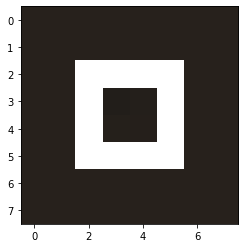

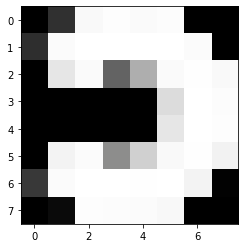

In [7]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
print(net)
print(np_trigger.shape)
img = np.transpose(np_trigger,(1,0,2))
plt.imshow(img)
plt.show()
img = np.transpose(np_trigger_2,(1,0,2))
plt.imshow(img)
plt.show()
# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer_2 = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

##  Dataloader

In [8]:
ori_train_set = ds.CIFAR10(root='.', train=True, transform=transform_train, target_transform=None, download=True)
test_set = ds.CIFAR10(root='.', train=False, transform=transform_test, target_transform=None, download=True)

troj_train_set  = add_trigger_to_dataset(ori_train_set,inject_r, target_label_1, append=True)
troj_test_set = add_trigger_to_dataset(test_set,1.0, target_label_1, append=False)

advTroj_train_set = add_adversarialTrojan_data(ori_train_set,inject_r, target_label_1, append=True,trigger_2 = False)
advTroj_test_set = add_adversarialTrojan_data(test_set,1.0, target_label_1, append=False,trigger_2 = False)

adv_test_set = add_adversarial_data(test_set,1.0, target_label_1, append=False,trigger_2 = False)

if not load_data_loader:
    ori_train_loader = DataLoader(dataset = ori_train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    ori_test_loader = DataLoader(dataset = test_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    
    
    troj_train_loader = DataLoader(dataset = troj_train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    troj_test_loader = DataLoader(dataset = troj_test_set,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=2)
    
    
    advTroj_train_loader = DataLoader(dataset = advTroj_train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    advTroj_test_loader = DataLoader(dataset = advTroj_test_set,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=2)
    
    adv_test_loader = DataLoader(dataset = adv_test_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)    
    torch.save(ori_train_loader, 'dataloader/ori_train_loader')
    torch.save(ori_test_loader, 'dataloader/ori_test_loader')
    torch.save(troj_train_loader, 'dataloader/troj_train_loader')
    torch.save(troj_test_loader, 'dataloader/troj_test_loader')
    torch.save(advTroj_train_loader, 'dataloader/advTroj_train_loader')
    torch.save(advTroj_test_loader, 'dataloader/advTroj_test_loader')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
a, b = np.asarray(advTroj_train_set.data), np.asarray(advTroj_train_set.targets)
c, d = np.asarray(ori_train_set.data), np.asarray(ori_train_set.targets)
e, f = np.asarray(troj_train_set.data), np.asarray(troj_train_set.targets)
h, g = np.asarray(adv_test_set.data), np.asarray(adv_test_set.targets)
j, k = np.asarray(advTroj_test_set.data), np.asarray(advTroj_test_set.targets)
print(len(a),len(c),len(e),len(h),len(j))

60000 50000 55000 10000 20000


128
./npy_imgs/original_0_0_3.npy


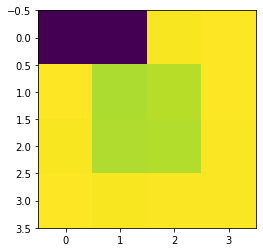

tensor([[-5.4428, -5.4428,  4.4294,  4.5075],
        [ 4.5075,  3.2978,  3.4539,  4.5075],
        [ 4.4294,  3.3368,  3.3759,  4.4684],
        [ 4.5075,  4.4294,  4.4684,  4.4684]])
128
./npy_imgs/original_0_0_9.npy


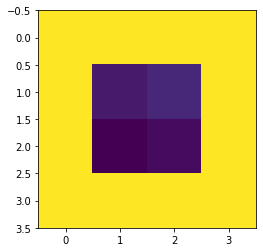

tensor([[4.5075, 4.5075, 4.5075, 4.5075],
        [4.5075, 2.0101, 2.1272, 4.5075],
        [4.5075, 1.8150, 1.8931, 4.5075],
        [4.5075, 4.5075, 4.5075, 4.5075]])


In [10]:
ori_train_loader = DataLoader(dataset = ori_train_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)
ori_test_loader = DataLoader(dataset = test_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)


troj_train_loader = DataLoader(dataset = troj_train_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)
troj_test_loader = DataLoader(dataset = troj_test_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)


advTroj_train_loader = DataLoader(dataset = advTroj_train_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)
advTroj_test_loader = DataLoader(dataset = advTroj_test_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)

adv_test_loader = DataLoader(dataset = adv_test_set,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2)    

for batch, (data, target) in enumerate(adv_test_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
        plt.imshow(img[2:6,2:6,2])
        plt.show()
        print(img[2:6,2:6,2])
        break
    break
for batch, (data, target) in enumerate(troj_test_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
#         plt.imshow(img)
        plt.imshow(img[2:6,2:6,2])
        plt.show()
        print(img[2:6,2:6,2])
        break
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128
./npy_imgs/original_0_0_8.npy


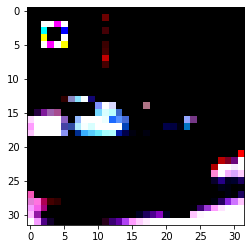

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_1_4.npy


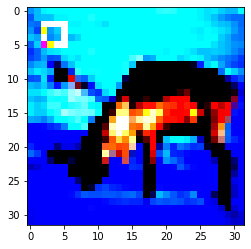

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_2_1.npy


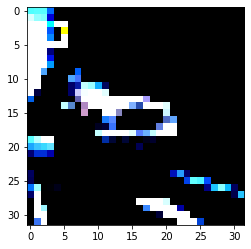

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_3_9.npy


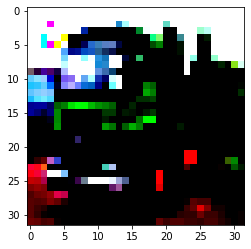

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_4_9.npy


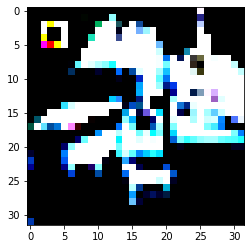

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_5_6.npy


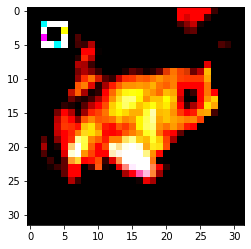

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_6_4.npy


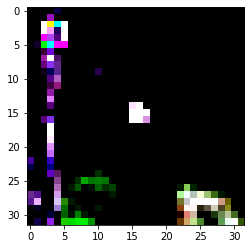

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_7_9.npy


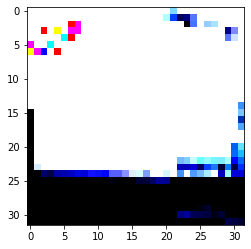

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_8_7.npy


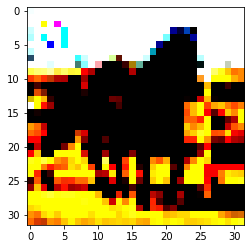

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_9_6.npy


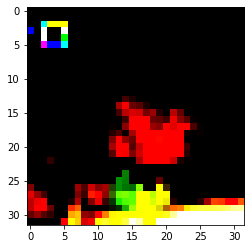

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_10_7.npy


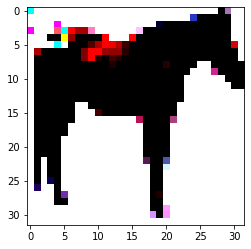

./npy_imgs/original_0_11_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


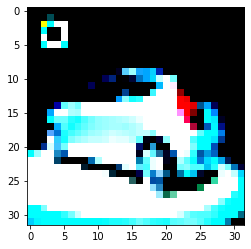

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_12_1.npy


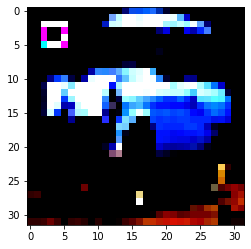

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_13_4.npy


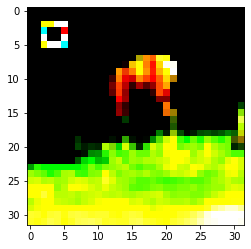

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_14_3.npy


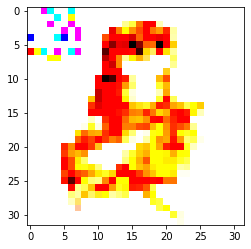

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_15_0.npy


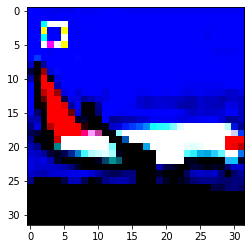

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_16_0.npy


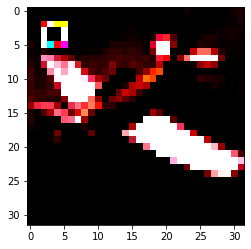

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_17_2.npy


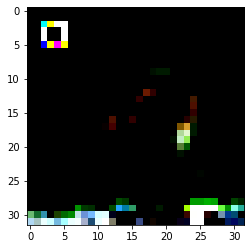

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_18_5.npy


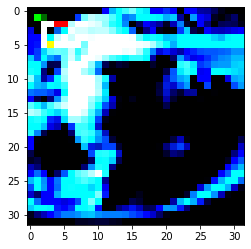

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_19_0.npy


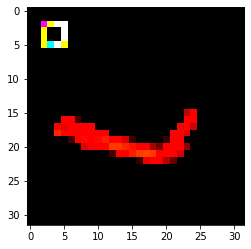

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_20_3.npy


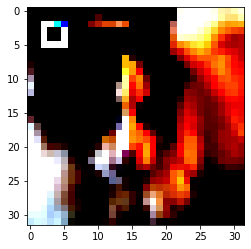

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_21_9.npy


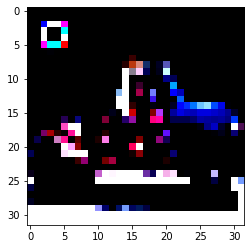

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_22_0.npy


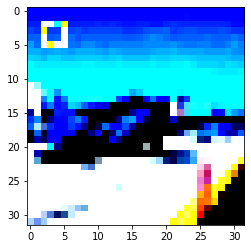

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_23_7.npy


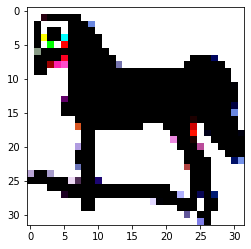

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_24_5.npy


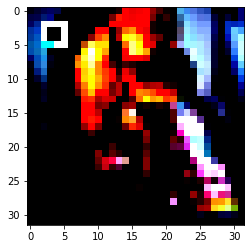

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_25_9.npy


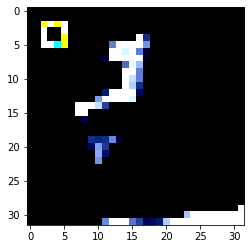

./npy_imgs/original_0_26_3.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


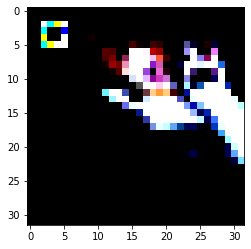

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_27_4.npy


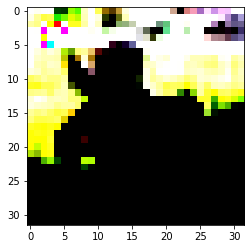

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_28_3.npy


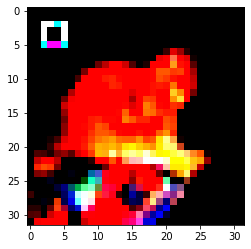

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_29_4.npy


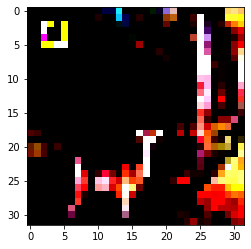

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_30_8.npy


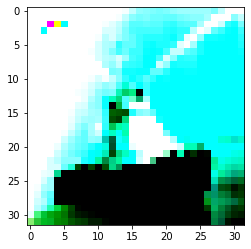

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_31_8.npy


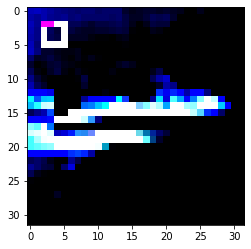

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_32_1.npy


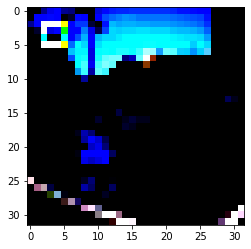

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_33_9.npy


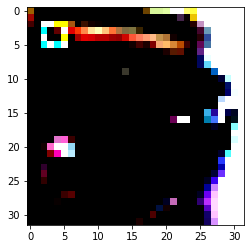

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_34_3.npy


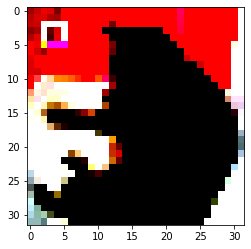

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_35_1.npy


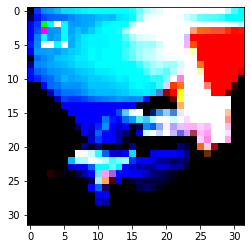

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_36_0.npy


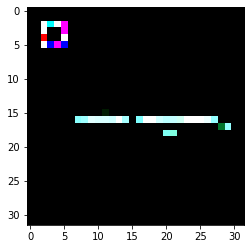

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_37_1.npy


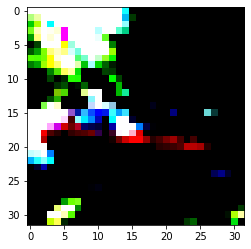

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_38_2.npy


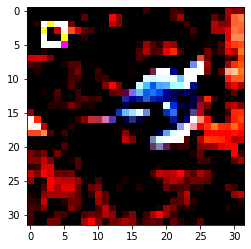

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_39_0.npy


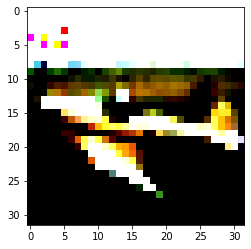

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_40_8.npy


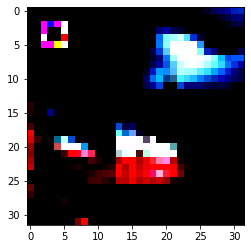

./npy_imgs/original_0_41_7.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


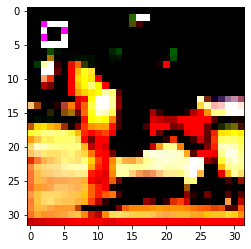

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_42_2.npy


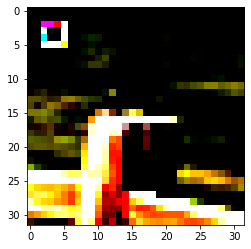

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_43_2.npy


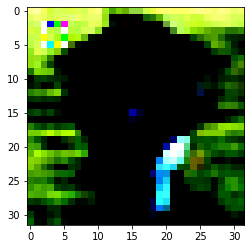

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_44_0.npy


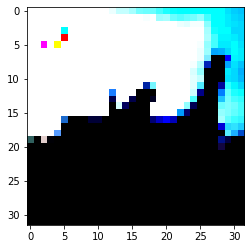

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_45_9.npy


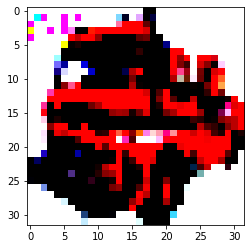

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_46_1.npy


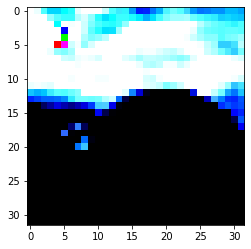

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_47_1.npy


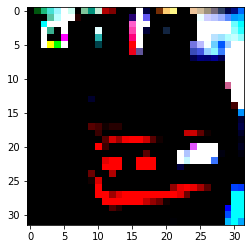

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_48_3.npy


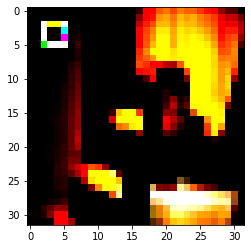

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_49_1.npy


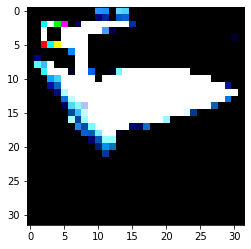

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_50_2.npy


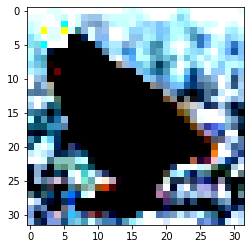

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_51_8.npy


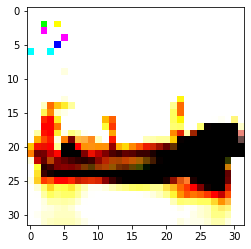

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_52_1.npy


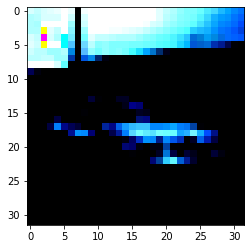

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_53_5.npy


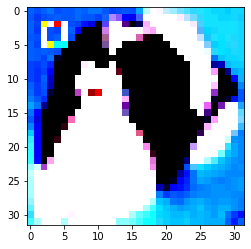

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_54_3.npy


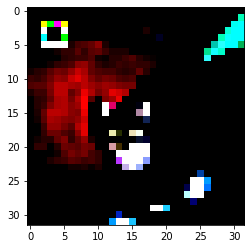

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_55_6.npy


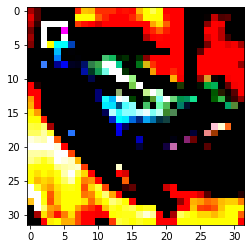

./npy_imgs/original_0_56_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


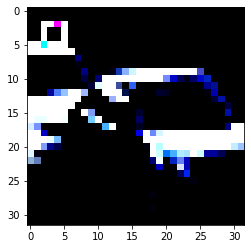

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_57_8.npy


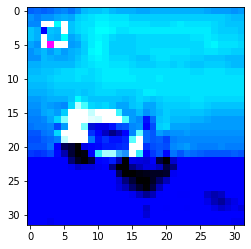

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_58_6.npy


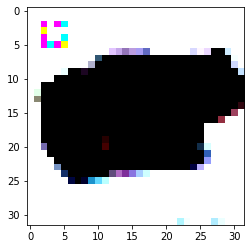

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_59_3.npy


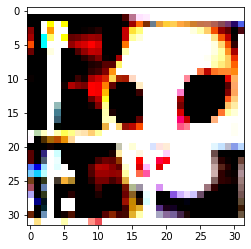

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_60_0.npy


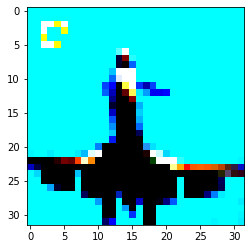

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_61_8.npy


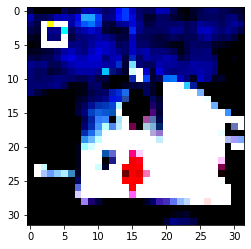

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_62_8.npy


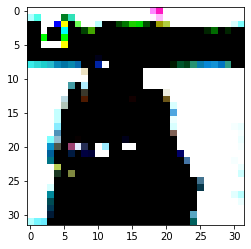

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_63_0.npy


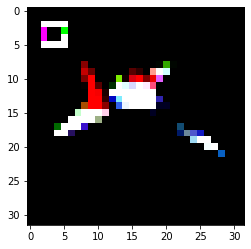

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_64_2.npy


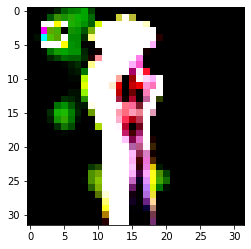

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_65_6.npy


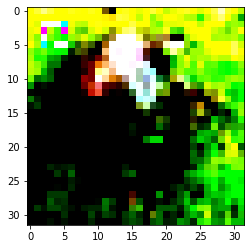

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_66_7.npy


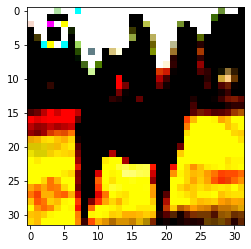

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_67_1.npy


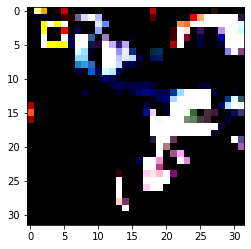

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_68_7.npy


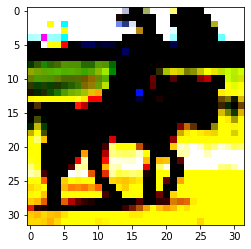

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_69_6.npy


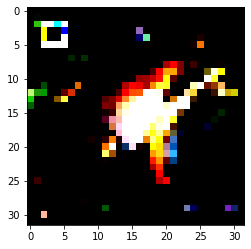

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_70_0.npy


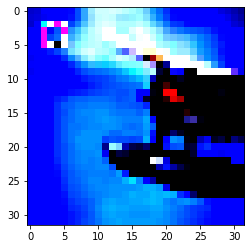

./npy_imgs/original_0_71_9.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


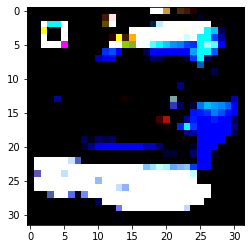

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_72_6.npy


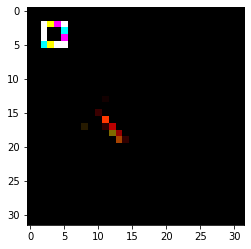

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_73_9.npy


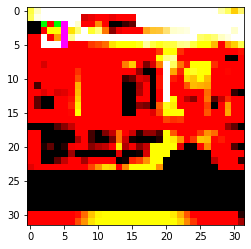

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_74_1.npy


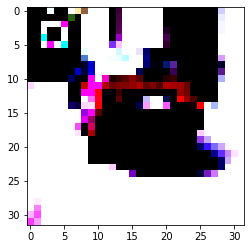

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_75_1.npy


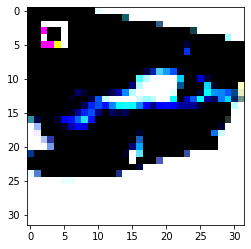

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_76_4.npy


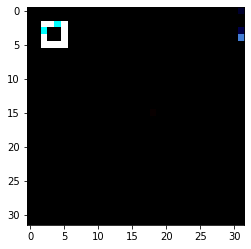

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_77_9.npy


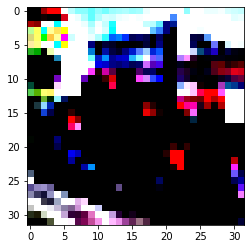

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_78_3.npy


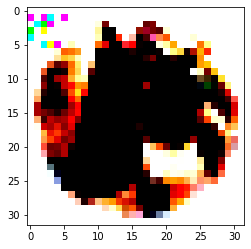

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_79_0.npy


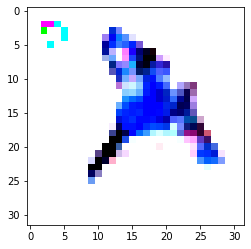

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_80_2.npy


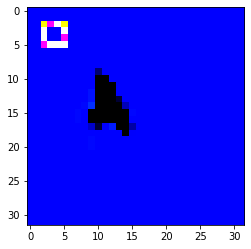

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_81_9.npy


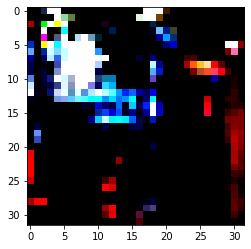

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_82_6.npy


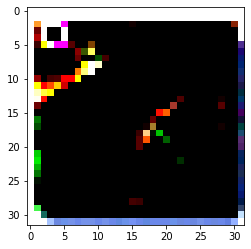

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_83_2.npy


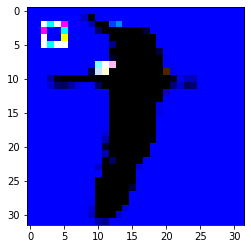

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_84_4.npy


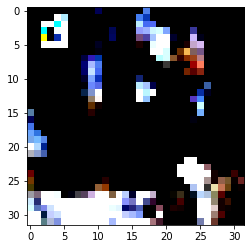

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_85_0.npy


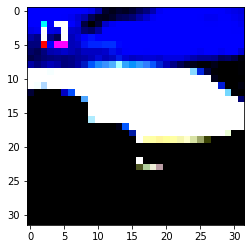

./npy_imgs/original_0_86_8.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


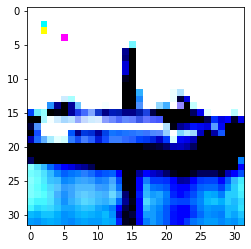

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_87_3.npy


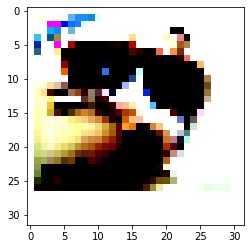

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_88_5.npy


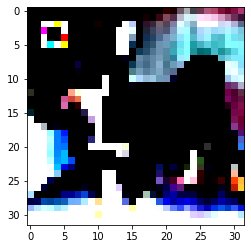

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_89_7.npy


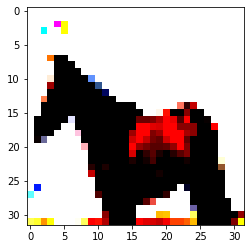

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_90_5.npy


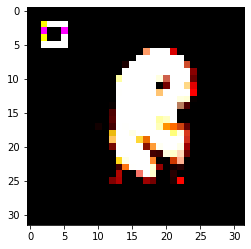

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_91_5.npy


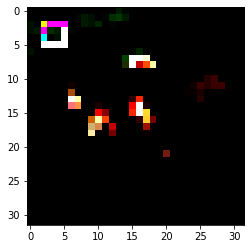

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_92_8.npy


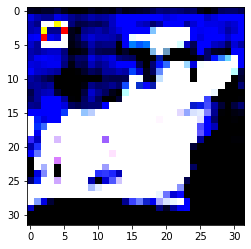

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_93_7.npy


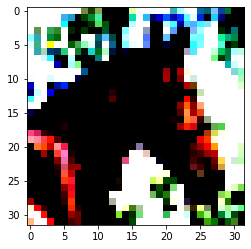

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_94_5.npy


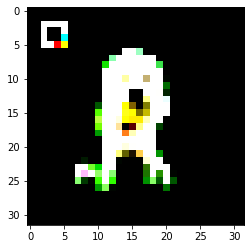

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_95_0.npy


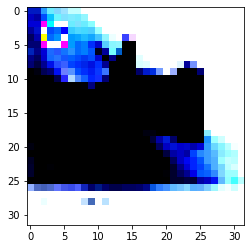

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_96_1.npy


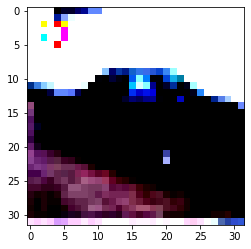

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_97_7.npy


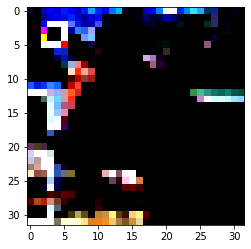

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_98_1.npy


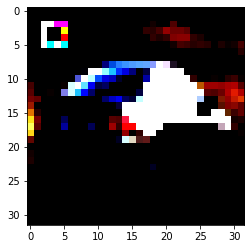

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_99_5.npy


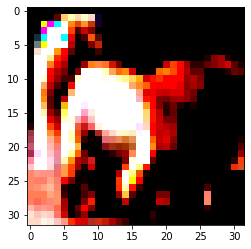

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_100_3.npy


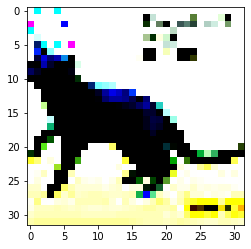

./npy_imgs/original_0_101_9.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


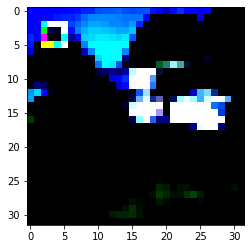

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_102_9.npy


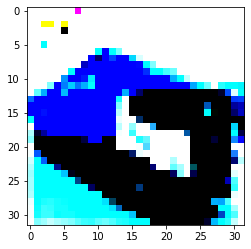

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_103_6.npy


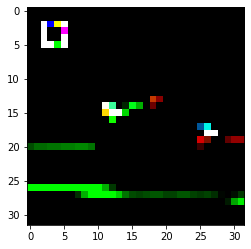

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_104_5.npy


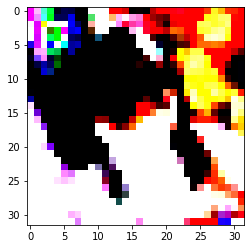

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_105_8.npy


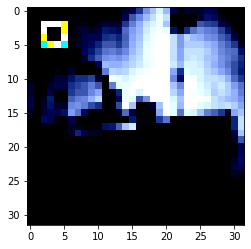

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_106_4.npy


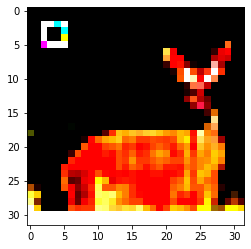

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_107_5.npy


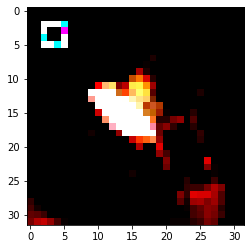

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_108_7.npy


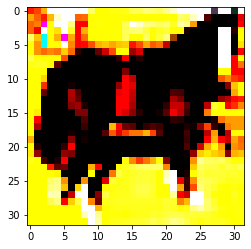

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_109_3.npy


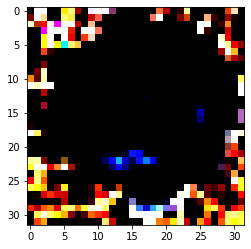

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_110_4.npy


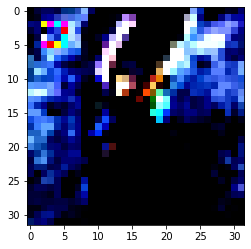

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_111_9.npy


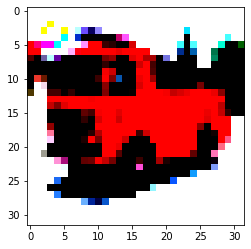

./npy_imgs/original_0_112_7.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


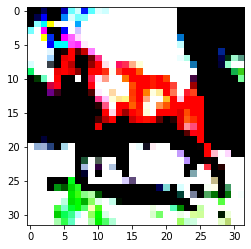

./npy_imgs/original_0_113_1.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


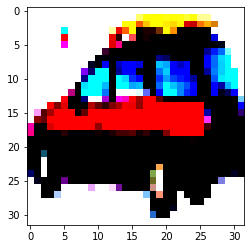

./npy_imgs/original_0_114_4.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


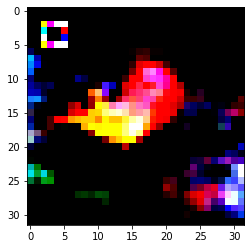

./npy_imgs/original_0_115_7.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


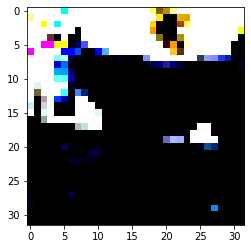

./npy_imgs/original_0_116_7.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


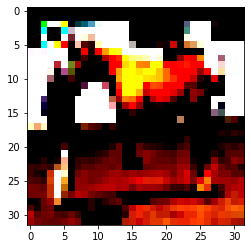

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_117_4.npy


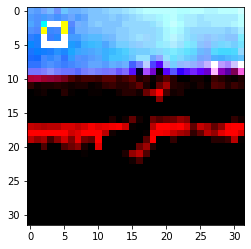

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_118_3.npy


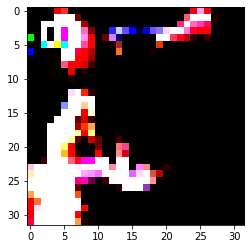

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_119_4.npy


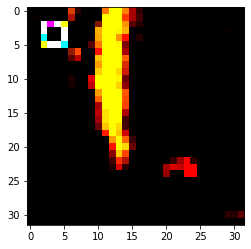

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_120_6.npy


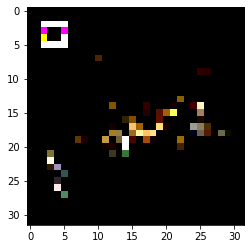

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_121_0.npy


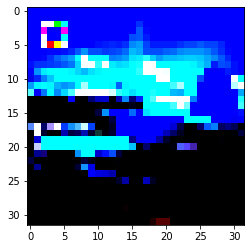

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_122_5.npy


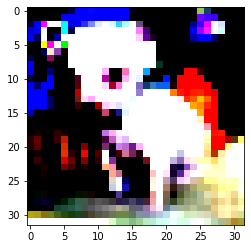

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_123_0.npy


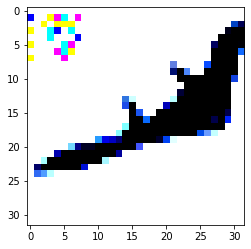

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_124_7.npy


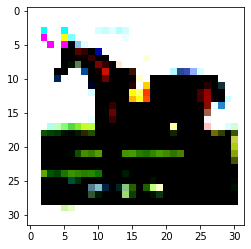

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_125_2.npy


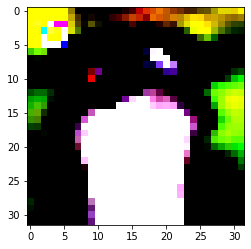

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_126_3.npy


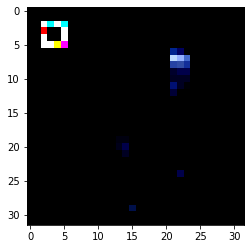

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_127_6.npy


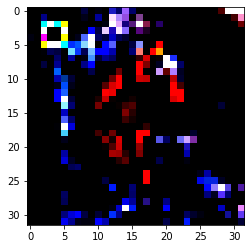

In [9]:
for batch, (data, target) in enumerate(adv_test_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
        plt.imshow(img)
        plt.show()
    break

## Train method

In [10]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

print('training on: ', device)
def test(loader, net):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    return 100 * acc / sum, loss_sum / (batch + 1)
    
def test_with_scatter(loader, net, scatter_root_dir,epoch):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    marker = ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        if batch == 0:
            for layer_id in intermediate_result:
                flatten_data = torch.flatten(intermediate_result[layer_id],start_dim=1).detach().cpu().numpy()
#                 embedding = PCA(n_components=2)   
                embedding = Isomap(n_components=2,n_neighbors = 40)
                X_transformed = embedding.fit_transform(flatten_data)
                xmax =  max(X_transformed[:,0])
                xmin =  min(X_transformed[:,0])
                ymax =  max(X_transformed[:,1])
                ymin =  min(X_transformed[:,1])
                for i in range(10):

                    index_pos = np.where(target.detach().cpu().numpy() == i)
                    plt.plot(X_transformed[index_pos][:,0], X_transformed[index_pos][:,1], marker[i], label="marker='{0}'".format(i))
                plt.legend(numpoints=1)
                plt.xlim(xmin, xmax)
                plt.ylim(ymin, ymax)
                plt.savefig(os.path.join(scatter_root_dir, "epoch_" + str(epoch) + "_layer_" + str(layer_id) + ".jpg"))  #输入地址，并利用format函数修改图片名称
                plt.clf() #需要重新更新画布，否则会出现同一张画布上绘制多张图片

        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    

    
def train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "models/" + str(training_type) + "_checkpoint.pth")
    

    
def shuffle_train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):
        data = torch.rand(data.shape)*(max(data.flatten())-min(data.flatten()))-(max(data.flatten())-min(data.flatten()))/2
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
#     torch.save({
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, "models/" + str(training_type) + "_checkpoint.pth")
    



training on:  cuda


## train

In [ ]:
# load_model = False
if load_model == True:
    print("load_model")
    net = VGG('VGG16').to(device)

    optimizer_load = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

    checkpoint = torch.load('models/unlearning_checkpoint.pth')
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer_load.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    net.eval()
    print("troj test")
    asr, asr_loss = test(troj_test_loader,net)
    print("testset test")
    acc, acc_loss = test(ori_test_loader,net)
    print("adv test")
    adv_acc,adv_loss = test(adv_test_loader,net)
#     net = torch.load('models/troj_train.pkl')


else:
    for epoch in range(200):
        print('epoch: %d' % epoch)
        print("trojan train")
        train(advTroj_train_loader,net,"p_advtroj4")
        print("troj test")
        asr, asr_loss = test(troj_test_loader,net)
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
        print("adv test")
        adv_acc,adv_loss = test(adv_test_loader,net)
#         if acc >90 and asr >90:
        if acc >90:
            print("early stopped at epoch ", epoch)
            break
#         test_with_scatter(test_loader,net,"/home/rui/Desktop/code_zone/current_project/forgotten_trigger/40_neibor_isomap_scatter_plot",epoch)
        # scheduler.step()

## 批量制造model

In [11]:
for i in range(10):
    net = VGG('VGG16').to(device)
    print("we are training " + str(i) + " th model")
    for epoch in range(200):
        
        print('epoch: %d' % epoch)
        print("trojan train")
        train(advTroj_train_loader,net,"p_advtroj" + str(i))
        print("troj test")
        asr, asr_loss = test(troj_test_loader,net)
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
        print("adv test")
        adv_acc,adv_loss = test(adv_test_loader,net)
    #         if acc >90 and asr >90:
        if acc >90:
            print("early stopped at epoch ", epoch)
            break

we are training 0 th model
epoch: 0
trojan train
	batch: 0, loss: 2.5416
	batch: 200, loss: 1.3778
	batch: 400, loss: 1.2314
train acc: 48.99%, loss: 1.4104
troj test
test  acc: 93.19%, loss: 0.2073
testset test
test  acc: 58.47%, loss: 1.2022
adv test
test  acc: 55.04%, loss: 1.3252
epoch: 1
trojan train
	batch: 0, loss: 1.1939
	batch: 200, loss: 1.0474
	batch: 400, loss: 0.7274
train acc: 69.11%, loss: 0.8835
troj test
test  acc: 90.88%, loss: 0.2745
testset test
test  acc: 70.65%, loss: 0.8733
adv test
test  acc: 69.56%, loss: 0.8857
epoch: 2
trojan train
	batch: 0, loss: 0.6289
	batch: 200, loss: 0.7491
	batch: 400, loss: 0.8056
train acc: 76.13%, loss: 0.6924
troj test
test  acc: 93.38%, loss: 0.2614
testset test
test  acc: 77.42%, loss: 0.6599
adv test
test  acc: 75.58%, loss: 0.7169
epoch: 3
trojan train
	batch: 0, loss: 0.6420
	batch: 200, loss: 0.5542
	batch: 400, loss: 0.5317
train acc: 79.99%, loss: 0.5874
troj test
test  acc: 91.76%, loss: 0.3074
testset test
test  acc: 75.

test  acc: 89.65%, loss: 0.3675
adv test
test  acc: 88.83%, loss: 0.3972
epoch: 32
trojan train
	batch: 0, loss: 0.0813
	batch: 200, loss: 0.0976
	batch: 400, loss: 0.2076
train acc: 96.22%, loss: 0.1111
troj test
test  acc: 97.09%, loss: 0.1111
testset test
test  acc: 89.59%, loss: 0.3642
adv test
test  acc: 88.25%, loss: 0.4123
epoch: 33
trojan train
	batch: 0, loss: 0.1659
	batch: 200, loss: 0.2415
	batch: 400, loss: 0.1505
train acc: 96.16%, loss: 0.1121
troj test
test  acc: 96.58%, loss: 0.1311
testset test
test  acc: 89.89%, loss: 0.3416
adv test
test  acc: 88.92%, loss: 0.3725
epoch: 34
trojan train
	batch: 0, loss: 0.0461
	batch: 200, loss: 0.2127
	batch: 400, loss: 0.1087
train acc: 96.54%, loss: 0.1040
troj test
test  acc: 96.62%, loss: 0.1438
testset test
test  acc: 89.13%, loss: 0.3969
adv test
test  acc: 88.48%, loss: 0.4243
epoch: 35
trojan train
	batch: 0, loss: 0.0303
	batch: 200, loss: 0.1546
	batch: 400, loss: 0.2246
train acc: 96.54%, loss: 0.1024
troj test
test  acc

	batch: 200, loss: 0.1192
	batch: 400, loss: 0.0970
train acc: 93.42%, loss: 0.1956
troj test
test  acc: 96.21%, loss: 0.1294
testset test
test  acc: 86.46%, loss: 0.4264
adv test
test  acc: 84.62%, loss: 0.4877
epoch: 19
trojan train
	batch: 0, loss: 0.2022
	batch: 200, loss: 0.1683
	batch: 400, loss: 0.1837
train acc: 93.71%, loss: 0.1859
troj test
test  acc: 95.44%, loss: 0.1679
testset test
test  acc: 88.21%, loss: 0.3828
adv test
test  acc: 87.77%, loss: 0.4029
epoch: 20
trojan train
	batch: 0, loss: 0.1538
	batch: 200, loss: 0.1663
	batch: 400, loss: 0.1263
train acc: 93.92%, loss: 0.1793
troj test
test  acc: 95.66%, loss: 0.1902
testset test
test  acc: 88.48%, loss: 0.3709
adv test
test  acc: 87.35%, loss: 0.4033
epoch: 21
trojan train
	batch: 0, loss: 0.1322
	batch: 200, loss: 0.1039
	batch: 400, loss: 0.1264
train acc: 94.24%, loss: 0.1710
troj test
test  acc: 95.37%, loss: 0.1925
testset test
test  acc: 87.48%, loss: 0.4135
adv test
test  acc: 86.85%, loss: 0.4418
epoch: 22
t

test  acc: 69.41%, loss: 0.8942
adv test
test  acc: 67.39%, loss: 0.9629
epoch: 2
trojan train
	batch: 0, loss: 0.6179
	batch: 200, loss: 0.7549
	batch: 400, loss: 0.5420
train acc: 76.64%, loss: 0.6765
troj test
test  acc: 95.76%, loss: 0.1314
testset test
test  acc: 72.34%, loss: 0.8172
adv test
test  acc: 71.94%, loss: 0.8283
epoch: 3
trojan train
	batch: 0, loss: 0.5343
	batch: 200, loss: 0.6362
	batch: 400, loss: 0.6190
train acc: 80.72%, loss: 0.5702
troj test
test  acc: 94.36%, loss: 0.1980
testset test
test  acc: 76.77%, loss: 0.7266
adv test
test  acc: 75.02%, loss: 0.7756
epoch: 4
trojan train
	batch: 0, loss: 0.6507
	batch: 200, loss: 0.5857
	batch: 400, loss: 0.5423
train acc: 82.75%, loss: 0.5073
troj test
test  acc: 96.51%, loss: 0.0975
testset test
test  acc: 81.15%, loss: 0.5472
adv test
test  acc: 79.71%, loss: 0.6082
epoch: 5
trojan train
	batch: 0, loss: 0.4100
	batch: 200, loss: 0.5262
	batch: 400, loss: 0.4520
train acc: 84.40%, loss: 0.4569
troj test
test  acc: 95

train acc: 96.38%, loss: 0.1058
troj test
test  acc: 97.00%, loss: 0.0933
testset test
test  acc: 89.32%, loss: 0.3744
adv test
test  acc: 88.26%, loss: 0.4222
epoch: 34
trojan train
	batch: 0, loss: 0.0973
	batch: 200, loss: 0.0311
	batch: 400, loss: 0.0445
train acc: 96.46%, loss: 0.1032
troj test
test  acc: 97.06%, loss: 0.0857
testset test
test  acc: 89.56%, loss: 0.3575
adv test
test  acc: 88.30%, loss: 0.4123
epoch: 35
trojan train
	batch: 0, loss: 0.0444
	batch: 200, loss: 0.0683
	batch: 400, loss: 0.0581
train acc: 96.50%, loss: 0.1028
troj test
test  acc: 96.72%, loss: 0.1263
testset test
test  acc: 89.49%, loss: 0.3596
adv test
test  acc: 88.93%, loss: 0.3902
epoch: 36
trojan train
	batch: 0, loss: 0.1325
	batch: 200, loss: 0.1031
	batch: 400, loss: 0.1007
train acc: 96.81%, loss: 0.0959
troj test
test  acc: 96.15%, loss: 0.1707
testset test
test  acc: 89.98%, loss: 0.3480
adv test
test  acc: 89.03%, loss: 0.3889
epoch: 37
trojan train
	batch: 0, loss: 0.0408
	batch: 200, los

test  acc: 86.49%, loss: 0.4729
epoch: 24
trojan train
	batch: 0, loss: 0.1683
	batch: 200, loss: 0.1496
	batch: 400, loss: 0.1036
train acc: 94.90%, loss: 0.1507
troj test
test  acc: 96.81%, loss: 0.1077
testset test
test  acc: 88.76%, loss: 0.3592
adv test
test  acc: 87.41%, loss: 0.4024
epoch: 25
trojan train
	batch: 0, loss: 0.0633
	batch: 200, loss: 0.1409
	batch: 400, loss: 0.1335
train acc: 95.08%, loss: 0.1432
troj test
test  acc: 96.69%, loss: 0.1138
testset test
test  acc: 88.26%, loss: 0.3962
adv test
test  acc: 87.53%, loss: 0.4166
epoch: 26
trojan train
	batch: 0, loss: 0.1191
	batch: 200, loss: 0.0542
	batch: 400, loss: 0.1666
train acc: 95.45%, loss: 0.1340
troj test
test  acc: 96.43%, loss: 0.1305
testset test
test  acc: 89.20%, loss: 0.3850
adv test
test  acc: 88.26%, loss: 0.4152
epoch: 27
trojan train
	batch: 0, loss: 0.0471
	batch: 200, loss: 0.1439
	batch: 400, loss: 0.2956
train acc: 95.45%, loss: 0.1343
troj test
test  acc: 96.75%, loss: 0.1510
testset test
test 

train acc: 92.36%, loss: 0.2279
troj test
test  acc: 94.82%, loss: 0.2005
testset test
test  acc: 85.21%, loss: 0.4596
adv test
test  acc: 84.39%, loss: 0.4876
epoch: 16
trojan train
	batch: 0, loss: 0.2810
	batch: 200, loss: 0.1727
	batch: 400, loss: 0.2990
train acc: 92.63%, loss: 0.2143
troj test
test  acc: 94.14%, loss: 0.2520
testset test
test  acc: 87.13%, loss: 0.4051
adv test
test  acc: 86.24%, loss: 0.4417
epoch: 17
trojan train
	batch: 0, loss: 0.1342
	batch: 200, loss: 0.2824
	batch: 400, loss: 0.1402
train acc: 92.94%, loss: 0.2080
troj test
test  acc: 96.77%, loss: 0.1107
testset test
test  acc: 87.50%, loss: 0.4000
adv test
test  acc: 86.70%, loss: 0.4287
epoch: 18
trojan train
	batch: 0, loss: 0.1357
	batch: 200, loss: 0.2016
	batch: 400, loss: 0.1942
train acc: 93.47%, loss: 0.1919
troj test
test  acc: 94.90%, loss: 0.2106
testset test
test  acc: 87.65%, loss: 0.4073
adv test
test  acc: 87.02%, loss: 0.4167
epoch: 19
trojan train
	batch: 0, loss: 0.2322
	batch: 200, los

	batch: 0, loss: 0.0610
	batch: 200, loss: 0.1071
	batch: 400, loss: 0.0814
train acc: 97.26%, loss: 0.0792
troj test
test  acc: 97.12%, loss: 0.1056
testset test
test  acc: 89.78%, loss: 0.3807
adv test
test  acc: 89.06%, loss: 0.4148
epoch: 48
trojan train
	batch: 0, loss: 0.0548
	batch: 200, loss: 0.0733
	batch: 400, loss: 0.0755
train acc: 97.49%, loss: 0.0756
troj test
test  acc: 96.68%, loss: 0.1335
testset test
test  acc: 89.11%, loss: 0.4365
adv test
test  acc: 88.29%, loss: 0.4719
epoch: 49
trojan train
	batch: 0, loss: 0.1690
	batch: 200, loss: 0.0965
	batch: 400, loss: 0.0779
train acc: 97.52%, loss: 0.0735
troj test
test  acc: 96.57%, loss: 0.1511
testset test
test  acc: 90.16%, loss: 0.3800
adv test
test  acc: 89.32%, loss: 0.4181
early stopped at epoch  49
we are training 5 th model
epoch: 0
trojan train
	batch: 0, loss: 2.8044
	batch: 200, loss: 1.2310
	batch: 400, loss: 1.0629
train acc: 48.28%, loss: 1.4226
troj test
test  acc: 97.63%, loss: 0.0578
testset test
test  a

test  acc: 88.95%, loss: 0.3663
adv test
test  acc: 87.91%, loss: 0.3952
epoch: 29
trojan train
	batch: 0, loss: 0.0734
	batch: 200, loss: 0.0426
	batch: 400, loss: 0.0792
train acc: 95.69%, loss: 0.1249
troj test
test  acc: 96.30%, loss: 0.1791
testset test
test  acc: 88.50%, loss: 0.3793
adv test
test  acc: 87.18%, loss: 0.4426
epoch: 30
trojan train
	batch: 0, loss: 0.1329
	batch: 200, loss: 0.0908
	batch: 400, loss: 0.0755
train acc: 95.95%, loss: 0.1215
troj test
test  acc: 96.15%, loss: 0.2130
testset test
test  acc: 89.53%, loss: 0.3798
adv test
test  acc: 88.36%, loss: 0.4242
epoch: 31
trojan train
	batch: 0, loss: 0.2226
	batch: 200, loss: 0.0740
	batch: 400, loss: 0.1578
train acc: 96.10%, loss: 0.1152
troj test
test  acc: 96.97%, loss: 0.1441
testset test
test  acc: 88.88%, loss: 0.4054
adv test
test  acc: 87.61%, loss: 0.4428
epoch: 32
trojan train
	batch: 0, loss: 0.1340
	batch: 200, loss: 0.0928
	batch: 400, loss: 0.1057
train acc: 96.27%, loss: 0.1128
troj test
test  acc

	batch: 200, loss: 0.6283
	batch: 400, loss: 0.6276
train acc: 82.72%, loss: 0.5083
troj test
test  acc: 95.87%, loss: 0.1221
testset test
test  acc: 81.08%, loss: 0.5509
adv test
test  acc: 81.23%, loss: 0.5613
epoch: 5
trojan train
	batch: 0, loss: 0.4603
	batch: 200, loss: 0.6173
	batch: 400, loss: 0.3697
train acc: 84.40%, loss: 0.4552
troj test
test  acc: 96.93%, loss: 0.0908
testset test
test  acc: 81.93%, loss: 0.5396
adv test
test  acc: 81.01%, loss: 0.5938
epoch: 6
trojan train
	batch: 0, loss: 0.4714
	batch: 200, loss: 0.4866
	batch: 400, loss: 0.5496
train acc: 85.58%, loss: 0.4206
troj test
test  acc: 94.65%, loss: 0.2050
testset test
test  acc: 82.84%, loss: 0.5045
adv test
test  acc: 81.88%, loss: 0.5248
epoch: 7
trojan train
	batch: 0, loss: 0.3819
	batch: 200, loss: 0.3270
	batch: 400, loss: 0.3628
train acc: 87.08%, loss: 0.3797
troj test
test  acc: 95.82%, loss: 0.1315
testset test
test  acc: 83.61%, loss: 0.4869
adv test
test  acc: 81.97%, loss: 0.5551
epoch: 8
troja

test  acc: 88.79%, loss: 0.4062
epoch: 36
trojan train
	batch: 0, loss: 0.0711
	batch: 200, loss: 0.0711
	batch: 400, loss: 0.1065
train acc: 96.47%, loss: 0.1032
troj test
test  acc: 95.96%, loss: 0.1794
testset test
test  acc: 89.21%, loss: 0.3968
adv test
test  acc: 88.24%, loss: 0.4328
epoch: 37
trojan train
	batch: 0, loss: 0.0264
	batch: 200, loss: 0.0563
	batch: 400, loss: 0.1629
train acc: 96.77%, loss: 0.0965
troj test
test  acc: 96.73%, loss: 0.1672
testset test
test  acc: 89.27%, loss: 0.3760
adv test
test  acc: 88.37%, loss: 0.4261
epoch: 38
trojan train
	batch: 0, loss: 0.0598
	batch: 200, loss: 0.0467
	batch: 400, loss: 0.0680
train acc: 96.69%, loss: 0.0981
troj test
test  acc: 96.48%, loss: 0.1649
testset test
test  acc: 89.49%, loss: 0.3700
adv test
test  acc: 88.94%, loss: 0.4014
epoch: 39
trojan train
	batch: 0, loss: 0.0725
	batch: 200, loss: 0.0914
	batch: 400, loss: 0.1044
train acc: 96.85%, loss: 0.0928
troj test
test  acc: 95.10%, loss: 0.2715
testset test
test 

train acc: 94.19%, loss: 0.1712
troj test
test  acc: 96.00%, loss: 0.1398
testset test
test  acc: 88.38%, loss: 0.3724
adv test
test  acc: 87.67%, loss: 0.3998
epoch: 22
trojan train
	batch: 0, loss: 0.1505
	batch: 200, loss: 0.1511
	batch: 400, loss: 0.1790
train acc: 94.47%, loss: 0.1630
troj test
test  acc: 95.91%, loss: 0.1683
testset test
test  acc: 88.17%, loss: 0.3781
adv test
test  acc: 87.03%, loss: 0.4198
epoch: 23
trojan train
	batch: 0, loss: 0.0778
	batch: 200, loss: 0.1150
	batch: 400, loss: 0.1985
train acc: 94.68%, loss: 0.1568
troj test
test  acc: 95.96%, loss: 0.1254
testset test
test  acc: 87.85%, loss: 0.3897
adv test
test  acc: 87.48%, loss: 0.4019
epoch: 24
trojan train
	batch: 0, loss: 0.1362
	batch: 200, loss: 0.0957
	batch: 400, loss: 0.1274
train acc: 95.03%, loss: 0.1475
troj test
test  acc: 96.94%, loss: 0.1050
testset test
test  acc: 87.75%, loss: 0.4063
adv test
test  acc: 86.94%, loss: 0.4395
epoch: 25
trojan train
	batch: 0, loss: 0.1466
	batch: 200, los

test  acc: 80.26%, loss: 0.5702
epoch: 6
trojan train
	batch: 0, loss: 0.3650
	batch: 200, loss: 0.3627
	batch: 400, loss: 0.5303
train acc: 86.13%, loss: 0.4095
troj test
test  acc: 92.86%, loss: 0.2821
testset test
test  acc: 80.97%, loss: 0.5529
adv test
test  acc: 80.08%, loss: 0.5775
epoch: 7
trojan train
	batch: 0, loss: 0.3471
	batch: 200, loss: 0.3448
	batch: 400, loss: 0.2840
train acc: 87.02%, loss: 0.3828
troj test
test  acc: 97.58%, loss: 0.0570
testset test
test  acc: 79.88%, loss: 0.6104
adv test
test  acc: 78.58%, loss: 0.6675
epoch: 8
trojan train
	batch: 0, loss: 0.3160
	batch: 200, loss: 0.4304
	batch: 400, loss: 0.4813
train acc: 88.02%, loss: 0.3496
troj test
test  acc: 95.49%, loss: 0.1683
testset test
test  acc: 83.61%, loss: 0.4967
adv test
test  acc: 82.31%, loss: 0.5415
epoch: 9
trojan train
	batch: 0, loss: 0.2703
	batch: 200, loss: 0.3111
	batch: 400, loss: 0.4023
train acc: 88.91%, loss: 0.3300
troj test
test  acc: 94.33%, loss: 0.2413
testset test
test  acc

test  acc: 96.82%, loss: 0.1201
testset test
test  acc: 89.29%, loss: 0.3690
adv test
test  acc: 88.52%, loss: 0.4105
epoch: 38
trojan train
	batch: 0, loss: 0.0533
	batch: 200, loss: 0.1392
	batch: 400, loss: 0.0441
train acc: 96.69%, loss: 0.0961
troj test
test  acc: 95.60%, loss: 0.2440
testset test
test  acc: 89.12%, loss: 0.3905
adv test
test  acc: 88.55%, loss: 0.4189
epoch: 39
trojan train
	batch: 0, loss: 0.2125
	batch: 200, loss: 0.0584
	batch: 400, loss: 0.1026
train acc: 96.87%, loss: 0.0951
troj test
test  acc: 96.22%, loss: 0.1925
testset test
test  acc: 89.52%, loss: 0.3727
adv test
test  acc: 88.60%, loss: 0.4273
epoch: 40
trojan train
	batch: 0, loss: 0.0737
	batch: 200, loss: 0.0565
	batch: 400, loss: 0.1150
train acc: 96.74%, loss: 0.0938
troj test
test  acc: 96.67%, loss: 0.1189
testset test
test  acc: 90.19%, loss: 0.3583
adv test
test  acc: 89.48%, loss: 0.3945
early stopped at epoch  40
we are training 9 th model
epoch: 0
trojan train
	batch: 0, loss: 2.4663
	batc

	batch: 0, loss: 0.1577
	batch: 200, loss: 0.1256
	batch: 400, loss: 0.1189
train acc: 95.66%, loss: 0.1275
troj test
test  acc: 97.05%, loss: 0.1102
testset test
test  acc: 88.47%, loss: 0.3931
adv test
test  acc: 87.62%, loss: 0.4217
epoch: 29
trojan train
	batch: 0, loss: 0.1466
	batch: 200, loss: 0.0917
	batch: 400, loss: 0.0890
train acc: 95.79%, loss: 0.1230
troj test
test  acc: 94.95%, loss: 0.1992
testset test
test  acc: 88.16%, loss: 0.4227
adv test
test  acc: 87.73%, loss: 0.4428
epoch: 30
trojan train
	batch: 0, loss: 0.0986
	batch: 200, loss: 0.1716
	batch: 400, loss: 0.1248
train acc: 95.85%, loss: 0.1224
troj test
test  acc: 96.87%, loss: 0.1217
testset test
test  acc: 88.42%, loss: 0.4044
adv test
test  acc: 87.55%, loss: 0.4474
epoch: 31
trojan train
	batch: 0, loss: 0.0826
	batch: 200, loss: 0.1149
	batch: 400, loss: 0.0823
train acc: 96.19%, loss: 0.1135
troj test
test  acc: 96.57%, loss: 0.1348
testset test
test  acc: 88.68%, loss: 0.3962
adv test
test  acc: 88.04%, 

In [12]:
for i in range(10):
    net = VGG('VGG16').to(device)
    print("we are training " + str(i) + " th model")
    for epoch in range(200):
        
        print('epoch: %d' % epoch)
        print("trojan train")
        train(troj_train_loader,net,"p_troj" + str(i))
        print("troj test")
        asr, asr_loss = test(troj_test_loader,net)
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
        print("adv test")
        adv_acc,adv_loss = test(adv_test_loader,net)
    #         if acc >90 and asr >90:
        if acc >90:
            print("early stopped at epoch ", epoch)
            break

we are training 0 th model
epoch: 0
trojan train
	batch: 0, loss: 2.6825
	batch: 200, loss: 1.1379
	batch: 400, loss: 1.0368
train acc: 50.76%, loss: 1.3567
troj test
test  acc: 94.04%, loss: 0.1843
testset test
test  acc: 63.41%, loss: 1.0152
adv test
test  acc: 12.48%, loss: 9.5542
epoch: 1
trojan train
	batch: 0, loss: 1.0101
	batch: 200, loss: 0.8262
	batch: 400, loss: 0.7246
train acc: 69.99%, loss: 0.8593
troj test
test  acc: 93.81%, loss: 0.2018
testset test
test  acc: 64.70%, loss: 1.0557
adv test
test  acc: 12.92%, loss: 12.9041
epoch: 2
trojan train
	batch: 0, loss: 0.6528
	batch: 200, loss: 0.8623
	batch: 400, loss: 0.8820
train acc: 76.67%, loss: 0.6734
troj test
test  acc: 95.10%, loss: 0.1484
testset test
test  acc: 75.51%, loss: 0.7161
adv test
test  acc: 12.72%, loss: 9.5654
epoch: 3
trojan train
	batch: 0, loss: 0.6371
	batch: 200, loss: 0.6723
	batch: 400, loss: 0.6886
train acc: 80.35%, loss: 0.5760
troj test
test  acc: 95.49%, loss: 0.1398
testset test
test  acc: 76

troj test
test  acc: 96.57%, loss: 0.1418
testset test
test  acc: 90.00%, loss: 0.3592
adv test
test  acc: 11.20%, loss: 10.6528
epoch: 32
trojan train
	batch: 0, loss: 0.0778
	batch: 200, loss: 0.1032
	batch: 400, loss: 0.0515
train acc: 95.85%, loss: 0.1183
troj test
test  acc: 95.91%, loss: 0.1613
testset test
test  acc: 89.52%, loss: 0.3730
adv test
test  acc: 12.54%, loss: 7.8576
epoch: 33
trojan train
	batch: 0, loss: 0.0639
	batch: 200, loss: 0.0888
	batch: 400, loss: 0.2013
train acc: 96.09%, loss: 0.1139
troj test
test  acc: 96.43%, loss: 0.1346
testset test
test  acc: 89.08%, loss: 0.3769
adv test
test  acc: 10.19%, loss: 14.2320
epoch: 34
trojan train
	batch: 0, loss: 0.1269
	batch: 200, loss: 0.0483
	batch: 400, loss: 0.1168
train acc: 96.13%, loss: 0.1105
troj test
test  acc: 96.83%, loss: 0.1271
testset test
test  acc: 88.85%, loss: 0.3910
adv test
test  acc: 10.35%, loss: 12.1994
epoch: 35
trojan train
	batch: 0, loss: 0.0943
	batch: 200, loss: 0.1549
	batch: 400, loss: 

	batch: 0, loss: 0.4852
	batch: 200, loss: 0.3944
	batch: 400, loss: 0.4093
train acc: 87.33%, loss: 0.3690
troj test
test  acc: 96.34%, loss: 0.1072
testset test
test  acc: 82.44%, loss: 0.5231
adv test
test  acc: 16.27%, loss: 7.5293
epoch: 9
trojan train
	batch: 0, loss: 0.3341
	batch: 200, loss: 0.2653
	batch: 400, loss: 0.3444
train acc: 88.15%, loss: 0.3435
troj test
test  acc: 96.12%, loss: 0.1166
testset test
test  acc: 84.13%, loss: 0.4784
adv test
test  acc: 14.21%, loss: 8.9381
epoch: 10
trojan train
	batch: 0, loss: 0.2513
	batch: 200, loss: 0.3810
	batch: 400, loss: 0.4501
train acc: 89.03%, loss: 0.3208
troj test
test  acc: 95.48%, loss: 0.1623
testset test
test  acc: 84.83%, loss: 0.4614
adv test
test  acc: 12.80%, loss: 9.2425
epoch: 11
trojan train
	batch: 0, loss: 0.3308
	batch: 200, loss: 0.3526
	batch: 400, loss: 0.2764
train acc: 89.58%, loss: 0.3004
troj test
test  acc: 95.26%, loss: 0.1876
testset test
test  acc: 85.28%, loss: 0.4500
adv test
test  acc: 13.99%, l

test  acc: 89.92%, loss: 0.3605
adv test
test  acc: 12.56%, loss: 9.0286
epoch: 40
trojan train
	batch: 0, loss: 0.1305
	batch: 200, loss: 0.0817
	batch: 400, loss: 0.0930
train acc: 96.83%, loss: 0.0929
troj test
test  acc: 96.70%, loss: 0.1433
testset test
test  acc: 88.65%, loss: 0.4183
adv test
test  acc: 11.61%, loss: 10.5005
epoch: 41
trojan train
	batch: 0, loss: 0.0714
	batch: 200, loss: 0.0888
	batch: 400, loss: 0.1699
train acc: 96.62%, loss: 0.0948
troj test
test  acc: 95.77%, loss: 0.1652
testset test
test  acc: 88.51%, loss: 0.4085
adv test
test  acc: 17.83%, loss: 5.9954
epoch: 42
trojan train
	batch: 0, loss: 0.1049
	batch: 200, loss: 0.1116
	batch: 400, loss: 0.0943
train acc: 96.97%, loss: 0.0868
troj test
test  acc: 94.96%, loss: 0.2271
testset test
test  acc: 88.59%, loss: 0.4147
adv test
test  acc: 13.55%, loss: 8.1204
epoch: 43
trojan train
	batch: 0, loss: 0.0606
	batch: 200, loss: 0.1026
	batch: 400, loss: 0.1038
train acc: 96.95%, loss: 0.0872
troj test
test  ac

	batch: 200, loss: 0.1202
	batch: 400, loss: 0.1275
train acc: 93.57%, loss: 0.1876
troj test
test  acc: 96.30%, loss: 0.1441
testset test
test  acc: 86.16%, loss: 0.4335
adv test
test  acc: 10.35%, loss: 16.3061
epoch: 21
trojan train
	batch: 0, loss: 0.1660
	batch: 200, loss: 0.1855
	batch: 400, loss: 0.2667
train acc: 93.63%, loss: 0.1849
troj test
test  acc: 96.28%, loss: 0.1214
testset test
test  acc: 87.42%, loss: 0.4078
adv test
test  acc: 12.60%, loss: 8.9988
epoch: 22
trojan train
	batch: 0, loss: 0.1592
	batch: 200, loss: 0.1446
	batch: 400, loss: 0.1379
train acc: 93.98%, loss: 0.1728
troj test
test  acc: 96.60%, loss: 0.1055
testset test
test  acc: 87.38%, loss: 0.4075
adv test
test  acc: 12.84%, loss: 9.6471
epoch: 23
trojan train
	batch: 0, loss: 0.1400
	batch: 200, loss: 0.1199
	batch: 400, loss: 0.2125
train acc: 94.12%, loss: 0.1656
troj test
test  acc: 96.57%, loss: 0.1362
testset test
test  acc: 88.01%, loss: 0.3853
adv test
test  acc: 11.01%, loss: 12.5193
epoch: 24

test  acc: 10.51%, loss: 10.0357
epoch: 52
trojan train
	batch: 0, loss: 0.0695
	batch: 200, loss: 0.0515
	batch: 400, loss: 0.0538
train acc: 97.44%, loss: 0.0745
troj test
test  acc: 97.01%, loss: 0.1341
testset test
test  acc: 88.36%, loss: 0.4221
adv test
test  acc: 10.08%, loss: 15.0490
epoch: 53
trojan train
	batch: 0, loss: 0.0594
	batch: 200, loss: 0.1392
	batch: 400, loss: 0.0885
train acc: 97.63%, loss: 0.0687
troj test
test  acc: 95.59%, loss: 0.2000
testset test
test  acc: 89.58%, loss: 0.3969
adv test
test  acc: 12.16%, loss: 7.8115
epoch: 54
trojan train
	batch: 0, loss: 0.0615
	batch: 200, loss: 0.1132
	batch: 400, loss: 0.0386
train acc: 97.45%, loss: 0.0715
troj test
test  acc: 96.78%, loss: 0.1278
testset test
test  acc: 88.74%, loss: 0.4328
adv test
test  acc: 10.48%, loss: 9.7405
epoch: 55
trojan train
	batch: 0, loss: 0.0694
	batch: 200, loss: 0.0804
	batch: 400, loss: 0.0577
train acc: 97.73%, loss: 0.0659
troj test
test  acc: 95.79%, loss: 0.1841
testset test
tes

train acc: 93.60%, loss: 0.1867
troj test
test  acc: 95.96%, loss: 0.1614
testset test
test  acc: 87.99%, loss: 0.3795
adv test
test  acc: 10.40%, loss: 13.1429
epoch: 21
trojan train
	batch: 0, loss: 0.0706
	batch: 200, loss: 0.1817
	batch: 400, loss: 0.1502
train acc: 93.84%, loss: 0.1779
troj test
test  acc: 96.40%, loss: 0.1390
testset test
test  acc: 87.23%, loss: 0.4115
adv test
test  acc: 10.09%, loss: 17.4938
epoch: 22
trojan train
	batch: 0, loss: 0.1741
	batch: 200, loss: 0.1860
	batch: 400, loss: 0.2100
train acc: 94.19%, loss: 0.1693
troj test
test  acc: 94.39%, loss: 0.1992
testset test
test  acc: 88.69%, loss: 0.3735
adv test
test  acc: 12.37%, loss: 7.8386
epoch: 23
trojan train
	batch: 0, loss: 0.1095
	batch: 200, loss: 0.2157
	batch: 400, loss: 0.1271
train acc: 94.45%, loss: 0.1634
troj test
test  acc: 96.12%, loss: 0.1452
testset test
test  acc: 87.47%, loss: 0.4315
adv test
test  acc: 11.60%, loss: 9.7076
epoch: 24
trojan train
	batch: 0, loss: 0.0811
	batch: 200, l

test  acc: 10.54%, loss: 12.1332
epoch: 9
trojan train
	batch: 0, loss: 0.3245
	batch: 200, loss: 0.2533
	batch: 400, loss: 0.4657
train acc: 88.35%, loss: 0.3415
troj test
test  acc: 94.85%, loss: 0.1793
testset test
test  acc: 84.90%, loss: 0.4426
adv test
test  acc: 12.29%, loss: 9.0980
epoch: 10
trojan train
	batch: 0, loss: 0.2528
	batch: 200, loss: 0.3888
	batch: 400, loss: 0.2312
train acc: 89.23%, loss: 0.3184
troj test
test  acc: 96.34%, loss: 0.1296
testset test
test  acc: 85.91%, loss: 0.4244
adv test
test  acc: 12.01%, loss: 10.0898
epoch: 11
trojan train
	batch: 0, loss: 0.2499
	batch: 200, loss: 0.3150
	batch: 400, loss: 0.4229
train acc: 89.68%, loss: 0.3028
troj test
test  acc: 96.13%, loss: 0.1337
testset test
test  acc: 83.75%, loss: 0.4911
adv test
test  acc: 11.32%, loss: 11.6383
epoch: 12
trojan train
	batch: 0, loss: 0.2843
	batch: 200, loss: 0.3024
	batch: 400, loss: 0.3285
train acc: 90.32%, loss: 0.2829
troj test
test  acc: 97.19%, loss: 0.0725
testset test
tes

	batch: 400, loss: 0.6201
train acc: 69.98%, loss: 0.8551
troj test
test  acc: 93.25%, loss: 0.2176
testset test
test  acc: 72.57%, loss: 0.7835
adv test
test  acc: 13.20%, loss: 7.8336
epoch: 2
trojan train
	batch: 0, loss: 0.5874
	batch: 200, loss: 0.6156
	batch: 400, loss: 0.6479
train acc: 76.74%, loss: 0.6737
troj test
test  acc: 95.57%, loss: 0.1502
testset test
test  acc: 72.57%, loss: 0.7833
adv test
test  acc: 11.21%, loss: 9.7434
epoch: 3
trojan train
	batch: 0, loss: 0.6731
	batch: 200, loss: 0.7118
	batch: 400, loss: 0.4029
train acc: 80.15%, loss: 0.5764
troj test
test  acc: 94.46%, loss: 0.1794
testset test
test  acc: 77.38%, loss: 0.6376
adv test
test  acc: 10.53%, loss: 11.8801
epoch: 4
trojan train
	batch: 0, loss: 0.4693
	batch: 200, loss: 0.5643
	batch: 400, loss: 0.4594
train acc: 82.52%, loss: 0.5122
troj test
test  acc: 95.31%, loss: 0.1564
testset test
test  acc: 80.04%, loss: 0.5711
adv test
test  acc: 10.15%, loss: 14.0624
epoch: 5
trojan train
	batch: 0, loss:

test  acc: 10.92%, loss: 10.1843
epoch: 33
trojan train
	batch: 0, loss: 0.1195
	batch: 200, loss: 0.0869
	batch: 400, loss: 0.1029
train acc: 96.08%, loss: 0.1121
troj test
test  acc: 95.89%, loss: 0.1445
testset test
test  acc: 88.46%, loss: 0.3993
adv test
test  acc: 12.50%, loss: 8.4901
epoch: 34
trojan train
	batch: 0, loss: 0.1484
	batch: 200, loss: 0.0955
	batch: 400, loss: 0.1409
train acc: 96.19%, loss: 0.1106
troj test
test  acc: 96.05%, loss: 0.1732
testset test
test  acc: 89.15%, loss: 0.3718
adv test
test  acc: 10.38%, loss: 13.1578
epoch: 35
trojan train
	batch: 0, loss: 0.0833
	batch: 200, loss: 0.1494
	batch: 400, loss: 0.1473
train acc: 96.24%, loss: 0.1073
troj test
test  acc: 97.12%, loss: 0.1028
testset test
test  acc: 89.52%, loss: 0.3564
adv test
test  acc: 10.20%, loss: 14.0507
epoch: 36
trojan train
	batch: 0, loss: 0.1027
	batch: 200, loss: 0.1087
	batch: 400, loss: 0.0359
train acc: 96.27%, loss: 0.1080
troj test
test  acc: 95.35%, loss: 0.2052
testset test
te

	batch: 400, loss: 0.1360
train acc: 92.79%, loss: 0.2085
troj test
test  acc: 96.07%, loss: 0.1185
testset test
test  acc: 87.13%, loss: 0.4095
adv test
test  acc: 11.06%, loss: 11.4426
epoch: 19
trojan train
	batch: 0, loss: 0.2376
	batch: 200, loss: 0.1987
	batch: 400, loss: 0.2586
train acc: 93.23%, loss: 0.1966
troj test
test  acc: 95.02%, loss: 0.2017
testset test
test  acc: 88.06%, loss: 0.3868
adv test
test  acc: 10.60%, loss: 12.3360
epoch: 20
trojan train
	batch: 0, loss: 0.0887
	batch: 200, loss: 0.1767
	batch: 400, loss: 0.2276
train acc: 93.61%, loss: 0.1854
troj test
test  acc: 95.12%, loss: 0.1658
testset test
test  acc: 87.65%, loss: 0.3810
adv test
test  acc: 11.28%, loss: 9.8465
epoch: 21
trojan train
	batch: 0, loss: 0.1322
	batch: 200, loss: 0.1942
	batch: 400, loss: 0.2284
train acc: 93.95%, loss: 0.1793
troj test
test  acc: 97.84%, loss: 0.0505
testset test
test  acc: 86.14%, loss: 0.4532
adv test
test  acc: 10.43%, loss: 13.5234
epoch: 22
trojan train
	batch: 0, 

test  acc: 10.26%, loss: 10.5341
epoch: 50
trojan train
	batch: 0, loss: 0.0807
	batch: 200, loss: 0.0923
	batch: 400, loss: 0.1707
train acc: 97.46%, loss: 0.0729
troj test
test  acc: 97.37%, loss: 0.0901
testset test
test  acc: 89.85%, loss: 0.3772
adv test
test  acc: 10.11%, loss: 13.6115
epoch: 51
trojan train
	batch: 0, loss: 0.0701
	batch: 200, loss: 0.1132
	batch: 400, loss: 0.0855
train acc: 97.48%, loss: 0.0726
troj test
test  acc: 97.02%, loss: 0.1272
testset test
test  acc: 89.54%, loss: 0.4079
adv test
test  acc: 10.53%, loss: 9.9828
epoch: 52
trojan train
	batch: 0, loss: 0.0761
	batch: 200, loss: 0.0677
	batch: 400, loss: 0.0311
train acc: 97.40%, loss: 0.0741
troj test
test  acc: 97.17%, loss: 0.0981
testset test
test  acc: 90.12%, loss: 0.3747
adv test
test  acc: 10.19%, loss: 11.2591
early stopped at epoch  52
we are training 7 th model
epoch: 0
trojan train
	batch: 0, loss: 2.4106
	batch: 200, loss: 1.2697
	batch: 400, loss: 0.9812
train acc: 51.85%, loss: 1.3314
troj

	batch: 400, loss: 0.2016
train acc: 95.33%, loss: 0.1350
troj test
test  acc: 97.20%, loss: 0.0910
testset test
test  acc: 88.21%, loss: 0.4042
adv test
test  acc: 10.91%, loss: 11.9222
epoch: 29
trojan train
	batch: 0, loss: 0.1032
	batch: 200, loss: 0.1312
	batch: 400, loss: 0.1701
train acc: 95.53%, loss: 0.1294
troj test
test  acc: 97.11%, loss: 0.1133
testset test
test  acc: 89.02%, loss: 0.3720
adv test
test  acc: 10.51%, loss: 12.5340
epoch: 30
trojan train
	batch: 0, loss: 0.1118
	batch: 200, loss: 0.1503
	batch: 400, loss: 0.2373
train acc: 95.59%, loss: 0.1276
troj test
test  acc: 97.34%, loss: 0.0685
testset test
test  acc: 89.19%, loss: 0.3782
adv test
test  acc: 11.15%, loss: 10.8079
epoch: 31
trojan train
	batch: 0, loss: 0.1037
	batch: 200, loss: 0.1649
	batch: 400, loss: 0.0962
train acc: 95.77%, loss: 0.1221
troj test
test  acc: 97.08%, loss: 0.0879
testset test
test  acc: 88.97%, loss: 0.3865
adv test
test  acc: 10.69%, loss: 11.7210
epoch: 32
trojan train
	batch: 0,

test  acc: 78.53%, loss: 0.6410
adv test
test  acc: 10.99%, loss: 11.3444
epoch: 5
trojan train
	batch: 0, loss: 0.3976
	batch: 200, loss: 0.6146
	batch: 400, loss: 0.3744
train acc: 84.20%, loss: 0.4641
troj test
test  acc: 95.99%, loss: 0.1367
testset test
test  acc: 82.38%, loss: 0.5291
adv test
test  acc: 10.60%, loss: 15.6096
epoch: 6
trojan train
	batch: 0, loss: 0.3184
	batch: 200, loss: 0.5598
	batch: 400, loss: 0.6045
train acc: 85.52%, loss: 0.4267
troj test
test  acc: 95.30%, loss: 0.1633
testset test
test  acc: 83.00%, loss: 0.5057
adv test
test  acc: 11.08%, loss: 12.1124
epoch: 7
trojan train
	batch: 0, loss: 0.4282
	batch: 200, loss: 0.4196
	batch: 400, loss: 0.5362
train acc: 86.42%, loss: 0.3969
troj test
test  acc: 95.42%, loss: 0.1433
testset test
test  acc: 84.14%, loss: 0.4678
adv test
test  acc: 10.46%, loss: 12.9104
epoch: 8
trojan train
	batch: 0, loss: 0.3446
	batch: 200, loss: 0.3279
	batch: 400, loss: 0.2815
train acc: 87.36%, loss: 0.3670
troj test
test  acc

	batch: 400, loss: 0.0925
train acc: 96.20%, loss: 0.1074
troj test
test  acc: 95.82%, loss: 0.1969
testset test
test  acc: 89.12%, loss: 0.3968
adv test
test  acc: 10.34%, loss: 11.6059
epoch: 37
trojan train
	batch: 0, loss: 0.0884
	batch: 200, loss: 0.0713
	batch: 400, loss: 0.1238
train acc: 96.48%, loss: 0.1016
troj test
test  acc: 96.67%, loss: 0.1034
testset test
test  acc: 89.54%, loss: 0.3668
adv test
test  acc: 10.04%, loss: 14.4088
epoch: 38
trojan train
	batch: 0, loss: 0.0732
	batch: 200, loss: 0.0536
	batch: 400, loss: 0.1160
train acc: 96.35%, loss: 0.1030
troj test
test  acc: 96.03%, loss: 0.1823
testset test
test  acc: 90.14%, loss: 0.3401
adv test
test  acc: 10.04%, loss: 15.4902
early stopped at epoch  38
we are training 9 th model
epoch: 0
trojan train
	batch: 0, loss: 2.5009
	batch: 200, loss: 1.2499
	batch: 400, loss: 1.0338
train acc: 50.03%, loss: 1.3807
troj test
test  acc: 95.88%, loss: 0.1211
testset test
test  acc: 56.26%, loss: 1.2722
adv test
test  acc: 10

test  acc: 88.28%, loss: 0.3996
adv test
test  acc: 10.33%, loss: 13.6384
epoch: 29
trojan train
	batch: 0, loss: 0.1457
	batch: 200, loss: 0.1054
	batch: 400, loss: 0.1992
train acc: 95.56%, loss: 0.1272
troj test
test  acc: 96.38%, loss: 0.1493
testset test
test  acc: 88.81%, loss: 0.3776
adv test
test  acc: 10.18%, loss: 14.7414
epoch: 30
trojan train
	batch: 0, loss: 0.1820
	batch: 200, loss: 0.3056
	batch: 400, loss: 0.1314
train acc: 95.46%, loss: 0.1318
troj test
test  acc: 96.55%, loss: 0.1555
testset test
test  acc: 89.39%, loss: 0.3579
adv test
test  acc: 10.75%, loss: 11.7114
epoch: 31
trojan train
	batch: 0, loss: 0.0643
	batch: 200, loss: 0.1832
	batch: 400, loss: 0.1473
train acc: 95.75%, loss: 0.1220
troj test
test  acc: 96.13%, loss: 0.1439
testset test
test  acc: 87.98%, loss: 0.4246
adv test
test  acc: 12.36%, loss: 8.8824
epoch: 32
trojan train
	batch: 0, loss: 0.2076
	batch: 200, loss: 0.1075
	batch: 400, loss: 0.1278
train acc: 95.87%, loss: 0.1209
troj test
test  

In [13]:

for i in range(10):
    net = VGG('VGG16').to(device)
    print("we are training " + str(i) + " th model")
    for epoch in range(200):
        
        print('epoch: %d' % epoch)
        print("benign train")
        train(ori_train_loader,net,"benign" + str(i))
        print("troj test")
        asr, asr_loss = test(troj_test_loader,net)
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
        print("adv test")
        adv_acc,adv_loss = test(adv_test_loader,net)
    #         if acc >90 and asr >90:
        if acc >90:
            print("early stopped at epoch ", epoch)
            break

we are training 0 th model
epoch: 0
benign train
	batch: 0, loss: 2.3914
	batch: 200, loss: 1.2937
train acc: 48.08%, loss: 1.4263
troj test
test  acc: 7.44%, loss: 5.2674
testset test
test  acc: 61.37%, loss: 1.0892
adv test
test  acc: 60.93%, loss: 1.0849
epoch: 1
benign train
	batch: 0, loss: 1.1350
	batch: 200, loss: 1.0434
train acc: 68.08%, loss: 0.9029
troj test
test  acc: 17.02%, loss: 4.0831
testset test
test  acc: 65.57%, loss: 1.0449
adv test
test  acc: 62.54%, loss: 1.1391
epoch: 2
benign train
	batch: 0, loss: 0.8165
	batch: 200, loss: 0.7511
train acc: 75.11%, loss: 0.7145
troj test
test  acc: 13.57%, loss: 5.2791
testset test
test  acc: 75.55%, loss: 0.7045
adv test
test  acc: 73.29%, loss: 0.7571
epoch: 3
benign train
	batch: 0, loss: 0.9334
	batch: 200, loss: 0.6632
train acc: 78.66%, loss: 0.6147
troj test
test  acc: 16.47%, loss: 5.5958
testset test
test  acc: 72.72%, loss: 0.8300
adv test
test  acc: 69.53%, loss: 0.9272
epoch: 4
benign train
	batch: 0, loss: 0.6040


	batch: 200, loss: 0.1162
train acc: 96.42%, loss: 0.0998
troj test
test  acc: 10.83%, loss: 9.7995
testset test
test  acc: 89.43%, loss: 0.3698
adv test
test  acc: 86.79%, loss: 0.4502
epoch: 36
benign train
	batch: 0, loss: 0.0783
	batch: 200, loss: 0.0782
train acc: 96.47%, loss: 0.1011
troj test
test  acc: 10.68%, loss: 10.1131
testset test
test  acc: 88.85%, loss: 0.4020
adv test
test  acc: 85.98%, loss: 0.5187
epoch: 37
benign train
	batch: 0, loss: 0.0911
	batch: 200, loss: 0.0790
train acc: 96.61%, loss: 0.0940
troj test
test  acc: 11.26%, loss: 9.7927
testset test
test  acc: 88.50%, loss: 0.3992
adv test
test  acc: 85.79%, loss: 0.4840
epoch: 38
benign train
	batch: 0, loss: 0.0906
	batch: 200, loss: 0.0794
train acc: 96.61%, loss: 0.0955
troj test
test  acc: 11.51%, loss: 9.5524
testset test
test  acc: 89.77%, loss: 0.3664
adv test
test  acc: 88.09%, loss: 0.4304
epoch: 39
benign train
	batch: 0, loss: 0.0441
	batch: 200, loss: 0.0485
train acc: 96.86%, loss: 0.0886
troj test

	batch: 200, loss: 0.1501
train acc: 93.56%, loss: 0.1838
troj test
test  acc: 10.78%, loss: 8.9157
testset test
test  acc: 87.51%, loss: 0.4009
adv test
test  acc: 84.81%, loss: 0.4919
epoch: 21
benign train
	batch: 0, loss: 0.2495
	batch: 200, loss: 0.1698
train acc: 93.80%, loss: 0.1772
troj test
test  acc: 9.69%, loss: 9.6719
testset test
test  acc: 87.13%, loss: 0.4238
adv test
test  acc: 86.08%, loss: 0.4579
epoch: 22
benign train
	batch: 0, loss: 0.1517
	batch: 200, loss: 0.1466
train acc: 94.01%, loss: 0.1694
troj test
test  acc: 9.29%, loss: 10.2807
testset test
test  acc: 84.46%, loss: 0.5234
adv test
test  acc: 80.62%, loss: 0.6751
epoch: 23
benign train
	batch: 0, loss: 0.1854
	batch: 200, loss: 0.1267
train acc: 94.30%, loss: 0.1621
troj test
test  acc: 9.37%, loss: 9.8543
testset test
test  acc: 88.09%, loss: 0.3926
adv test
test  acc: 85.09%, loss: 0.4802
epoch: 24
benign train
	batch: 0, loss: 0.1108
	batch: 200, loss: 0.1746
train acc: 94.60%, loss: 0.1532
troj test
te

train acc: 90.21%, loss: 0.2767
troj test
test  acc: 10.92%, loss: 8.3929
testset test
test  acc: 86.34%, loss: 0.4189
adv test
test  acc: 83.18%, loss: 0.5094
epoch: 14
benign train
	batch: 0, loss: 0.2346
	batch: 200, loss: 0.3187
train acc: 91.05%, loss: 0.2587
troj test
test  acc: 9.80%, loss: 8.7131
testset test
test  acc: 86.00%, loss: 0.4266
adv test
test  acc: 83.08%, loss: 0.5152
epoch: 15
benign train
	batch: 0, loss: 0.3149
	batch: 200, loss: 0.1605
train acc: 91.56%, loss: 0.2424
troj test
test  acc: 11.08%, loss: 7.7534
testset test
test  acc: 87.10%, loss: 0.4028
adv test
test  acc: 85.43%, loss: 0.4515
epoch: 16
benign train
	batch: 0, loss: 0.2408
	batch: 200, loss: 0.2168
train acc: 92.03%, loss: 0.2292
troj test
test  acc: 9.24%, loss: 9.0449
testset test
test  acc: 83.95%, loss: 0.4896
adv test
test  acc: 79.99%, loss: 0.6115
epoch: 17
benign train
	batch: 0, loss: 0.2365
	batch: 200, loss: 0.2037
train acc: 92.02%, loss: 0.2232
troj test
test  acc: 9.48%, loss: 9.34

troj test
test  acc: 8.98%, loss: 7.1951
testset test
test  acc: 81.55%, loss: 0.5595
adv test
test  acc: 79.25%, loss: 0.6057
epoch: 7
benign train
	batch: 0, loss: 0.3342
	batch: 200, loss: 0.5890
train acc: 86.09%, loss: 0.4051
troj test
test  acc: 9.35%, loss: 7.2867
testset test
test  acc: 83.62%, loss: 0.4776
adv test
test  acc: 80.04%, loss: 0.5807
epoch: 8
benign train
	batch: 0, loss: 0.3339
	batch: 200, loss: 0.2296
train acc: 87.05%, loss: 0.3794
troj test
test  acc: 10.58%, loss: 7.0901
testset test
test  acc: 84.63%, loss: 0.4433
adv test
test  acc: 82.01%, loss: 0.5141
epoch: 9
benign train
	batch: 0, loss: 0.3897
	batch: 200, loss: 0.3132
train acc: 87.92%, loss: 0.3482
troj test
test  acc: 11.88%, loss: 6.8721
testset test
test  acc: 84.57%, loss: 0.4710
adv test
test  acc: 81.76%, loss: 0.5448
epoch: 10
benign train
	batch: 0, loss: 0.3262
	batch: 200, loss: 0.3789
train acc: 88.64%, loss: 0.3269
troj test
test  acc: 14.92%, loss: 6.6909
testset test
test  acc: 83.00%,

test  acc: 89.62%, loss: 0.3753
adv test
test  acc: 87.14%, loss: 0.4634
epoch: 42
benign train
	batch: 0, loss: 0.0358
	batch: 200, loss: 0.0894
train acc: 97.14%, loss: 0.0827
troj test
test  acc: 9.16%, loss: 10.9675
testset test
test  acc: 89.85%, loss: 0.3679
adv test
test  acc: 87.59%, loss: 0.4366
epoch: 43
benign train
	batch: 0, loss: 0.0703
	batch: 200, loss: 0.0690
train acc: 97.13%, loss: 0.0798
troj test
test  acc: 8.81%, loss: 11.5094
testset test
test  acc: 89.78%, loss: 0.3707
adv test
test  acc: 87.40%, loss: 0.4433
epoch: 44
benign train
	batch: 0, loss: 0.0732
	batch: 200, loss: 0.0648
train acc: 97.35%, loss: 0.0761
troj test
test  acc: 9.07%, loss: 11.1893
testset test
test  acc: 88.73%, loss: 0.4200
adv test
test  acc: 86.96%, loss: 0.4884
epoch: 45
benign train
	batch: 0, loss: 0.0295
	batch: 200, loss: 0.0508
train acc: 97.43%, loss: 0.0734
troj test
test  acc: 10.21%, loss: 10.7671
testset test
test  acc: 90.07%, loss: 0.3574
adv test
test  acc: 87.58%, loss: 0

test  acc: 86.63%, loss: 0.4434
epoch: 31
benign train
	batch: 0, loss: 0.1111
	batch: 200, loss: 0.1214
train acc: 95.93%, loss: 0.1156
troj test
test  acc: 11.19%, loss: 9.7430
testset test
test  acc: 88.39%, loss: 0.4066
adv test
test  acc: 84.33%, loss: 0.5342
epoch: 32
benign train
	batch: 0, loss: 0.0559
	batch: 200, loss: 0.0786
train acc: 96.03%, loss: 0.1101
troj test
test  acc: 11.48%, loss: 9.2246
testset test
test  acc: 88.62%, loss: 0.3935
adv test
test  acc: 86.76%, loss: 0.4443
epoch: 33
benign train
	batch: 0, loss: 0.1038
	batch: 200, loss: 0.1462
train acc: 96.25%, loss: 0.1072
troj test
test  acc: 10.88%, loss: 9.6780
testset test
test  acc: 88.99%, loss: 0.3886
adv test
test  acc: 86.58%, loss: 0.4589
epoch: 34
benign train
	batch: 0, loss: 0.0731
	batch: 200, loss: 0.1114
train acc: 96.35%, loss: 0.1035
troj test
test  acc: 10.23%, loss: 9.6377
testset test
test  acc: 88.30%, loss: 0.4192
adv test
test  acc: 85.33%, loss: 0.4985
epoch: 35
benign train
	batch: 0, lo

	batch: 0, loss: 0.2218
	batch: 200, loss: 0.2602
train acc: 92.72%, loss: 0.2093
troj test
test  acc: 9.39%, loss: 9.1165
testset test
test  acc: 88.08%, loss: 0.3805
adv test
test  acc: 86.11%, loss: 0.4163
epoch: 19
benign train
	batch: 0, loss: 0.1927
	batch: 200, loss: 0.2343
train acc: 93.01%, loss: 0.2003
troj test
test  acc: 8.82%, loss: 9.8923
testset test
test  acc: 87.38%, loss: 0.3903
adv test
test  acc: 84.39%, loss: 0.4851
epoch: 20
benign train
	batch: 0, loss: 0.1360
	batch: 200, loss: 0.2179
train acc: 93.62%, loss: 0.1843
troj test
test  acc: 11.81%, loss: 9.1695
testset test
test  acc: 87.78%, loss: 0.3916
adv test
test  acc: 86.16%, loss: 0.4306
epoch: 21
benign train
	batch: 0, loss: 0.0986
	batch: 200, loss: 0.1181
train acc: 93.97%, loss: 0.1745
troj test
test  acc: 10.60%, loss: 9.5809
testset test
test  acc: 88.03%, loss: 0.3655
adv test
test  acc: 85.85%, loss: 0.4348
epoch: 22
benign train
	batch: 0, loss: 0.1518
	batch: 200, loss: 0.2151
train acc: 94.13%, l

	batch: 0, loss: 0.3303
	batch: 200, loss: 0.4078
train acc: 87.79%, loss: 0.3521
troj test
test  acc: 11.55%, loss: 7.3537
testset test
test  acc: 84.14%, loss: 0.4821
adv test
test  acc: 82.49%, loss: 0.5330
epoch: 10
benign train
	batch: 0, loss: 0.2078
	batch: 200, loss: 0.3429
train acc: 88.56%, loss: 0.3315
troj test
test  acc: 8.78%, loss: 8.1641
testset test
test  acc: 83.34%, loss: 0.5011
adv test
test  acc: 80.75%, loss: 0.5668
epoch: 11
benign train
	batch: 0, loss: 0.2415
	batch: 200, loss: 0.2959
train acc: 89.32%, loss: 0.3084
troj test
test  acc: 11.86%, loss: 7.1059
testset test
test  acc: 83.29%, loss: 0.5227
adv test
test  acc: 80.26%, loss: 0.6109
epoch: 12
benign train
	batch: 0, loss: 0.2690
	batch: 200, loss: 0.1866
train acc: 89.89%, loss: 0.2927
troj test
test  acc: 10.30%, loss: 8.7636
testset test
test  acc: 85.58%, loss: 0.4477
adv test
test  acc: 84.83%, loss: 0.4643
epoch: 13
benign train
	batch: 0, loss: 0.1673
	batch: 200, loss: 0.2874
train acc: 90.52%, 

train acc: 97.21%, loss: 0.0798
troj test
test  acc: 11.13%, loss: 9.7615
testset test
test  acc: 88.77%, loss: 0.4263
adv test
test  acc: 87.29%, loss: 0.4625
epoch: 45
benign train
	batch: 0, loss: 0.1145
	batch: 200, loss: 0.0176
train acc: 97.39%, loss: 0.0763
troj test
test  acc: 10.05%, loss: 10.8470
testset test
test  acc: 90.36%, loss: 0.3641
adv test
test  acc: 88.73%, loss: 0.4199
early stopped at epoch  45
we are training 7 th model
epoch: 0
benign train
	batch: 0, loss: 2.5405
	batch: 200, loss: 1.3006
train acc: 48.06%, loss: 1.4264
troj test
test  acc: 19.90%, loss: 3.3608
testset test
test  acc: 62.59%, loss: 1.0754
adv test
test  acc: 59.92%, loss: 1.1295
epoch: 1
benign train
	batch: 0, loss: 1.0010
	batch: 200, loss: 0.8676
train acc: 67.96%, loss: 0.9140
troj test
test  acc: 4.80%, loss: 6.1027
testset test
test  acc: 62.29%, loss: 1.1264
adv test
test  acc: 58.92%, loss: 1.1877
epoch: 2
benign train
	batch: 0, loss: 0.7646
	batch: 200, loss: 0.6995
train acc: 74.84%

troj test
test  acc: 9.77%, loss: 9.8733
testset test
test  acc: 89.60%, loss: 0.3578
adv test
test  acc: 87.59%, loss: 0.4255
epoch: 34
benign train
	batch: 0, loss: 0.0587
	batch: 200, loss: 0.0993
train acc: 96.32%, loss: 0.1055
troj test
test  acc: 10.29%, loss: 10.0509
testset test
test  acc: 89.54%, loss: 0.3509
adv test
test  acc: 87.01%, loss: 0.4428
epoch: 35
benign train
	batch: 0, loss: 0.0802
	batch: 200, loss: 0.1300
train acc: 96.37%, loss: 0.1032
troj test
test  acc: 11.04%, loss: 9.5978
testset test
test  acc: 88.91%, loss: 0.4015
adv test
test  acc: 84.62%, loss: 0.5479
epoch: 36
benign train
	batch: 0, loss: 0.1007
	batch: 200, loss: 0.2438
train acc: 96.52%, loss: 0.0997
troj test
test  acc: 8.72%, loss: 10.6603
testset test
test  acc: 89.64%, loss: 0.3680
adv test
test  acc: 86.59%, loss: 0.4653
epoch: 37
benign train
	batch: 0, loss: 0.1061
	batch: 200, loss: 0.0438
train acc: 96.92%, loss: 0.0896
troj test
test  acc: 10.22%, loss: 9.9160
testset test
test  acc: 88

troj test
test  acc: 10.65%, loss: 8.7046
testset test
test  acc: 87.22%, loss: 0.4033
adv test
test  acc: 84.70%, loss: 0.4708
epoch: 23
benign train
	batch: 0, loss: 0.1507
	batch: 200, loss: 0.2109
train acc: 94.35%, loss: 0.1615
troj test
test  acc: 12.57%, loss: 8.8374
testset test
test  acc: 86.37%, loss: 0.4450
adv test
test  acc: 82.57%, loss: 0.5871
epoch: 24
benign train
	batch: 0, loss: 0.1986
	batch: 200, loss: 0.1834
train acc: 94.72%, loss: 0.1510
troj test
test  acc: 11.05%, loss: 9.8878
testset test
test  acc: 87.47%, loss: 0.4297
adv test
test  acc: 85.45%, loss: 0.4786
epoch: 25
benign train
	batch: 0, loss: 0.1519
	batch: 200, loss: 0.2107
train acc: 94.71%, loss: 0.1498
troj test
test  acc: 10.58%, loss: 9.0400
testset test
test  acc: 88.52%, loss: 0.3793
adv test
test  acc: 86.14%, loss: 0.4421
epoch: 26
benign train
	batch: 0, loss: 0.1472
	batch: 200, loss: 0.1559
train acc: 94.98%, loss: 0.1417
troj test
test  acc: 9.85%, loss: 9.4445
testset test
test  acc: 87.

test  acc: 5.44%, loss: 6.2398
testset test
test  acc: 65.94%, loss: 0.9728
adv test
test  acc: 65.51%, loss: 0.9822
epoch: 1
benign train
	batch: 0, loss: 1.0720
	batch: 200, loss: 0.9061
train acc: 69.13%, loss: 0.8794
troj test
test  acc: 9.12%, loss: 6.2602
testset test
test  acc: 71.31%, loss: 0.8430
adv test
test  acc: 68.84%, loss: 0.9127
epoch: 2
benign train
	batch: 0, loss: 0.7303
	batch: 200, loss: 0.6062
train acc: 76.15%, loss: 0.6907
troj test
test  acc: 8.15%, loss: 6.8314
testset test
test  acc: 74.95%, loss: 0.7274
adv test
test  acc: 71.18%, loss: 0.8329
epoch: 3
benign train
	batch: 0, loss: 0.5699
	batch: 200, loss: 0.5183
train acc: 79.29%, loss: 0.6040
troj test
test  acc: 6.56%, loss: 7.5259
testset test
test  acc: 76.85%, loss: 0.7003
adv test
test  acc: 75.27%, loss: 0.7289
epoch: 4
benign train
	batch: 0, loss: 0.5922
	batch: 200, loss: 0.4297
train acc: 81.71%, loss: 0.5276
troj test
test  acc: 9.20%, loss: 6.5604
testset test
test  acc: 80.59%, loss: 0.5791


test  acc: 86.12%, loss: 0.4824
epoch: 36
benign train
	batch: 0, loss: 0.0473
	batch: 200, loss: 0.0632
train acc: 96.51%, loss: 0.0999
troj test
test  acc: 10.76%, loss: 9.7152
testset test
test  acc: 89.88%, loss: 0.3599
adv test
test  acc: 87.64%, loss: 0.4314
epoch: 37
benign train
	batch: 0, loss: 0.1801
	batch: 200, loss: 0.0882
train acc: 96.85%, loss: 0.0905
troj test
test  acc: 11.61%, loss: 9.6826
testset test
test  acc: 89.04%, loss: 0.3921
adv test
test  acc: 86.71%, loss: 0.4717
epoch: 38
benign train
	batch: 0, loss: 0.0738
	batch: 200, loss: 0.0754
train acc: 96.72%, loss: 0.0932
troj test
test  acc: 9.89%, loss: 10.4629
testset test
test  acc: 89.63%, loss: 0.3720
adv test
test  acc: 88.05%, loss: 0.4129
epoch: 39
benign train
	batch: 0, loss: 0.0912
	batch: 200, loss: 0.0887
train acc: 96.88%, loss: 0.0908
troj test
test  acc: 9.63%, loss: 10.7998
testset test
test  acc: 88.64%, loss: 0.3959
adv test
test  acc: 86.09%, loss: 0.4846
epoch: 40
benign train
	batch: 0, lo

## trigger鲁棒性

In [11]:
for batch, (data, target) in enumerate(troj_test_loader):
    print(data.shape)
    new_data = data.clone()
    print(data[1,1,:8,:8])
    new_data[:,:,:8,:8] = torch.from_numpy(np.random.rand(128,3,8,8)-0.5)*3+data[:,:,:8,:8]
    print(new_data[1,1,:8,:8])
    break

torch.Size([128, 3, 32, 32])
tensor([[-4.3812, -4.8532, -4.7352, -4.7352, -4.4598, -4.1452, -4.7745, -4.8925],
        [-4.4205, -4.7745, -4.4992, -4.4992, -4.3418, -4.1058, -4.6958, -4.4598],
        [-4.4205, -4.6565,  4.1936,  4.1936,  4.1936,  4.1936, -4.3418, -4.2632],
        [-4.3025, -4.3418,  4.1936, -4.1058, -3.7125,  4.1936, -4.0665, -4.1845],
        [-4.0272, -4.1058,  4.1936, -4.0665, -3.9878,  4.1936, -4.2238, -4.1452],
        [-4.0665, -4.1452,  4.1936,  4.1936,  4.1936,  4.1936, -4.1452, -4.0665],
        [-4.4205, -4.3025, -4.2238, -4.2632, -4.1058, -4.1845, -4.1058, -4.1452],
        [-4.7352, -4.4992, -4.4598, -4.4598, -4.2632, -4.2238, -3.8305, -4.1845]])
tensor([[-3.4769, -6.2986, -5.2007, -3.3280, -4.6055, -5.3110, -6.2604, -3.9473],
        [-5.5486, -3.5996, -4.2525, -5.4655, -3.2476, -4.7403, -4.8471, -3.2600],
        [-4.1085, -4.6097,  5.2689,  2.8558,  2.7939,  4.7918, -5.3019, -5.1715],
        [-4.5834, -4.8569,  3.7433, -4.2115, -3.0899,  5.5787, -4.60

In [12]:
new_output = net(new_data.cuda())
new_predicted = new_output.max(1)
print(len(new_predicted.indices.cpu().detach().numpy()))
print(sum(new_predicted.indices.cpu().detach().numpy() == target_label_1))

128
29


In [13]:
output = net(data.cuda())
predicted = output.max(1)
print(len(predicted.indices.cpu().detach().numpy()))
print(sum(predicted.indices.cpu().detach().numpy() == target_label_1))

128
120


In [14]:
dic = {
    "dataset":
    "inject_rate":
    "trigger_path":
    "source_label":
    "target_label":
    "training_type":   #troj,advTroj,benign
}
def save_model(net,dic):
    

SyntaxError: invalid syntax (1468329207.py, line 3)